# Bachelier 

# General Imports and Settings

In [ ]:
# For Google Colab
%pip install jaxtyping
%pip install equinox

In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random
import jax

from typing import Sequence
from jaxtyping import Array, Float, Int, PyTree

import equinox as eqx
import optax
import chex

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass, astuple
from functools import partial

import numpy as np

import pytest
import pytest_benchmark

jax.enable_checks = True

jax.devices()

2023-06-14 15:39:16.395331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-14 15:39:19.452451: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[gpu(id=0)]

In [2]:
# list requirements
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

jax==0.4.12
equinox==0.10.5
optax==0.1.4
chex==0.1.7
tensorflow==2.12.0
tensorflow_datasets==4.9.2
numpy==1.23.5
pytest==7.3.1
pytest_benchmark==4.0.0


In [3]:
# test: edited with colab
NUM_EPOCHS = 100
# BATCH_SIZE = 256
BATCH_SIZE = 512
BUFFER_SIZE = 1024
# STEPS_PER_EPOCH = 16
LEARNING_RATE = 0.01
N_TRAINING_SAMPLES = 8 * 1024
N_TEST_SAMPLES = 4096
SEED = 42

In [4]:
@eqx.filter_jit
def value_and_jacrev(f, x):
    # Function that computes both the values and the Jacobian using reverse mode autodiff
    y, vjpfun = jax.vjp(f, x)  # Compute the values and obtain a VJP function
    basis = jnp.eye(y.size, dtype=y.dtype)
    jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    return y, jac, vjpfun

@eqx.filter_jit
def value_and_jacobian(f, x):
    y, jac, _ = value_and_jacrev(f, x)
    return y, jac

# Bachelier Dataset

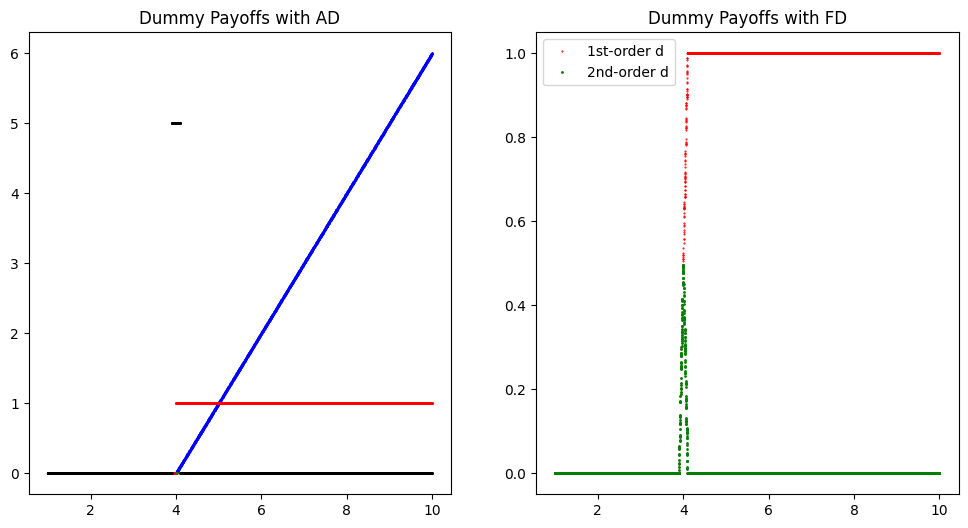

In [5]:
# plt.style.use('seaborn-poster')

def dummy_payoff(xs, K=4):
  return jnp.maximum(0, xs - K)

seed = 42
n = N_TRAINING_SAMPLES
key = random.PRNGKey(seed)
key, subkey = random.split(key)
xs = random.uniform(subkey, shape=(n,), minval=1.0, maxval=10.0)
ys = dummy_payoff(xs)

dpayoff = grad(dummy_payoff)
dys = vmap(dpayoff)(xs)
ddys = vmap(grad(dpayoff))(xs)

h = 0.1
fd_xph = vmap(dpayoff)(xs + h)
fd_xmh = vmap(dpayoff)(xs - h)
ddys_fd = (fd_xph - fd_xmh) / (2 * h)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot
axs[0].set_title("Dummy Payoffs with AD")
axs[0].plot(xs, ys, 'b.', markersize=1, label='values')
axs[0].plot(xs, dys, 'r.', markersize=1, label='1st-order d')
axs[0].plot(xs, ddys, 'g--', markersize=1, label='2nd-order d')
axs[0].plot(xs, ddys_fd, 'k.', markersize=1, label='2nd-order fd d')
# axs[0].legend()

h = 0.1
fd_xph = dummy_payoff(xs + h)
fd_xmh = dummy_payoff(xs - h)
fd = (fd_xph - fd_xmh) / (2 * h)
fdd = (fd_xph - 2 * ys + fd_xmh) / (2 * h)

# fd_over_fd = (fd_xph - fd_xmh) / (2 * h)

# hs = jnp.diag(jnp.ones_like(xs) * h)
# fd_xph = xs + hs
# fd_xmh = xs - hs
# fd_ = (fd_xph - fd_xmh) / (2 * h)
# fd = jnp.diag(fd_)
# print(xs)
# print(xs + hs)
# print(fd.shape)

# Second plot
axs[1].set_title("Dummy Payoffs with FD")
# axs[1].plot(xs, ys, 'b.', markersize=1, label='values')
# axs[1].plot(xs[:-1], fd, 'b.', markersize=1, label='1st-order d')
axs[1].plot(xs, fd, 'r.', markersize=1, label='1st-order d')
axs[1].plot(xs, fdd, 'g.', markersize=2, label='2nd-order d')
axs[1].legend()

plt.show()

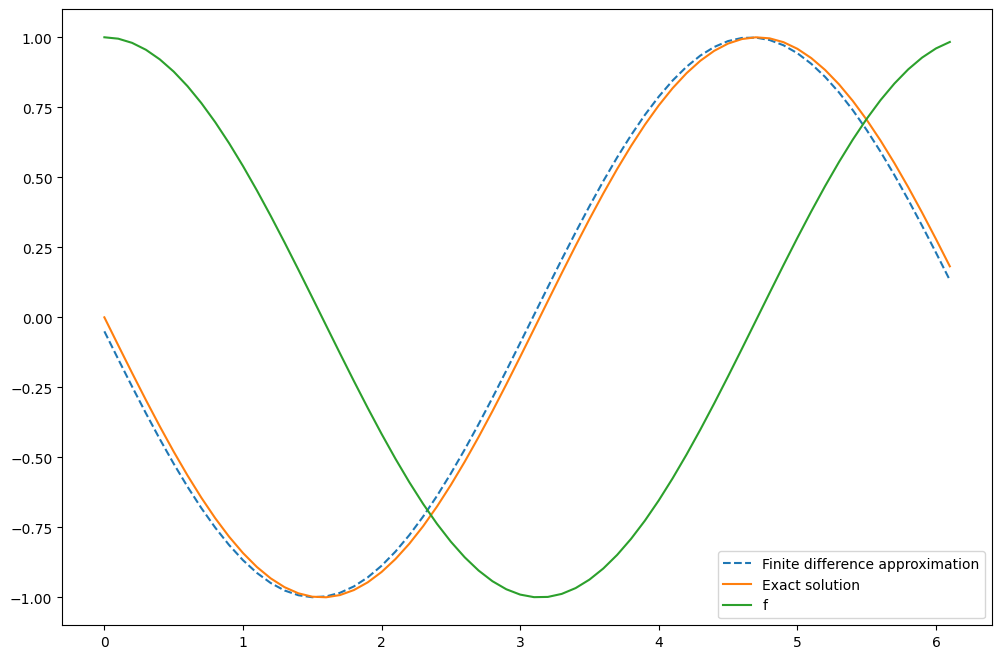

0.04998418


In [6]:
# step size
h = 0.1
# define grid
x = jnp.arange(0, 2*jnp.pi, h) 
# compute function
y = jnp.cos(x) 

# compute vector of forward differences
forward_diff = jnp.diff(y)/h 
# compute corresponding grid
x_diff = x[:-1:] 
# compute exact solution
exact_solution = -jnp.sin(x_diff) 

# Plot solution
plt.figure(figsize = (12, 8))
plt.plot(x_diff, forward_diff, '--', \
         label = 'Finite difference approximation')
plt.plot(x_diff, exact_solution, \
         label = 'Exact solution')
plt.plot(x_diff, jnp.cos(x_diff), label = 'f')
plt.legend()
plt.show()

# Compute max error between 
# numerical derivative and exact solution
max_error = max(abs(exact_solution - forward_diff))
print(max_error)


In [7]:
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)
    
# generates a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])


@dataclass(eq=True, frozen=True)
class BachelierParams:
    n_dim: int = 1
    T1: float = 1.0
    T2: float = 2.0
    K: float = 1.10
    test_set_lb = 0.5
    test_set_ub = 1.50
    volMult: float = 1.5
    bktVol: float = 0.2
    anti: bool = False

class TrainingSet(eqx.Module):
    X: Array 
    Y: Array
    Z: Array
    W: Array
    weights: Array
    inc1: Array
    Z_fd: Array
    W_fd_of_fd: Array
    W_fd_of_vjp: Array
    W_fd_of_grad: Array

    def shapes(self):
        jax.debug.print("X {X}, Y {Y}, Z {Z}, W {W}", X=X.shape, Y=Y.shape, Z=Z.shape, W=W.shape)

class TestSet(eqx.Module):
    spots: Array
    baskets: Array
    prices: Array
    deltas: Array
    vegas: Array

def plot_simulations(y0, y1):
  x = jnp.linspace(0, 100, y0.shape[0]) #[..., jnp.newaxis]
  print("X SHAPE: ", x.shape)
  print("Y0 SHAPE: ", y0.shape)
  print("Y1 SHAPE: ", y1.shape)
  plt.title(f"Simulations")
  # for i in range(x.shape[1]):
    # plt.plot(x[:, i], y[:, i], '.', markersize=1, label=f"ddyddx {i}")
  n = 1000
  plt.plot(x[:n], y0[:n])
  plt.plot(x[:n], y1[:n])
  plt.show()
 

def payoff_fn(X, inc1, a, K, anti=False):
    S2 = X + inc1
    bkt2 = jnp.dot(S2, a)
    pay = jnp.maximum(0, bkt2 - K)
    
    if anti: # two antithetic paths
        S2a = X - inc1
        bkt2a = jnp.dot(S2a, a)
        paya = jnp.maximum(0, bkt2a - K)
        
        Y = 0.5 * (pay + paya)
    else: # standard
        Y = pay

    return Y

def analytic_grad(X, inc1, a, K, anti=False):
    S2 = X + inc1
    bkt2 = jnp.dot(S2, a)
    pay = jnp.maximum(0, bkt2 - K)

    if anti: # two antithetic paths
        S2a = X - inc1
        bkt2a = jnp.dot(S2a, a)
        paya = jnp.maximum(0, bkt2a - K)
        
        # differentials
        Z1 =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        Z2 =  jnp.where(bkt2a > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        Z_analytic = 0.5 * (Z1 + Z2)
                
    else: # standard 
        Z_analytic = jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))

    return Z_analytic
           
# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3))
def trainingSet(m: int, params: BachelierParams, seed=2, bktVol=0.2) -> TrainingSet:
    n = params.n_dim
    T1 = params.T1
    T2 = params.T2
    K = params.K
    volMult = params.volMult
    anti = params.anti

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)

    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    vols = vols * bktVol / v
    jax.debug.print("vols is= {v}", v=vols)
    bktVol = bktVol
    jax.debug.print("bkt vol is= {v}", v=bktVol)

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))
    inc0 = normals[0, :, :] @ chol0.T
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

      
    payoff = partial(payoff_fn, a=a, K=K, anti=anti)

    Z_analytic = analytic_grad(S1, inc1, a, K, anti=anti)
    # Compute the values and obtain a VJP function
    Y_vjp, vjpfun = jax.vjp(payoff, S1, inc1)
    Z_vjp = vjpfun(jnp.ones(Y_vjp.size))[0]
    # if not independent, we need to use the commented out section instead
    # basis = jnp.eye(y.size, dtype=y.dtype)
    # Z_vjp = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function

    # using first order finite differences
    h = 1e-4
    fd_ph = payoff(S1 + h, inc1)
    fd_mh = payoff(S1 - h, inc1)
    Z_fd = (fd_ph - fd_mh) / (2 * h)

    # using second order finite differences
    h = 1e-2
    fdd = (fd_ph - 2 * Y_vjp + fd_mh) / (h * h)
    W_fd_of_fd = fdd[..., jnp.newaxis]

    # using first order finite difference over vjp
    h = 1e-4
    fd_of_vjp_ph = vjpfun(jnp.ones(Y_vjp.size) + h)[0]
    fd_of_vjp_mh  = vjpfun(jnp.ones(Y_vjp.size) - h)[0]
    W_fd_of_vjp = (fd_of_vjp_ph - fd_of_vjp_mh) / (2 * h)

    Dpayoff = vmap(jax.grad(payoff))
    W_fd_of_grad_ph = Dpayoff(S1 + h, inc1)
    W_fd_of_grad_mh = Dpayoff(S1 - h, inc1)
    W_fd_of_grad = (W_fd_of_grad_ph - W_fd_of_grad_mh) / (2 * h)

    Y, Z_grad = jax.vmap(jax.value_and_grad(payoff, argnums=0))(S1, inc1)

    jax.debug.print("W_fd_of_fd vs W_fd_of_vjp {mse}", mse=jnp.mean(jnp.square(W_fd_of_fd - W_fd_of_vjp)))
    jax.debug.print("Example values: {val1}, {val2}", val1=Z_grad[2,0], val2=Z_vjp[2,0])
    jax.debug.print("MSE(Z_grad, Z_analytic) = {res}", res=jnp.mean((Z_grad - Z_analytic)**2))
    jax.debug.print("MSE(Z_vjp, Z_analytic) = {res}", res=jnp.mean((Z_vjp - Z_analytic)**2))
    jax.debug.print("MSE(Y_vjp, Y) = {res}", res=jnp.mean((Y_vjp - Y)**2))
    jax.debug.print("Close(Y_vjp, Y) ? {res}", res=jnp.allclose(Y_vjp, Y))
    jax.debug.print("Close(Z_vjp, Z) ? {res}", res=jnp.allclose(Z_vjp, Z_analytic))
    jax.debug.print("Close(Z_grad, Z) ? {res}", res=jnp.allclose(Z_grad, Z_analytic))

    jax.debug.print("S1.shape {s}", s=S1.shape)

    W_hessian = jax.vmap(jax.hessian(payoff, argnums=0))(S1, inc1)
    
    X = S1
    return TrainingSet(X, Y_vjp.reshape(-1,1), Z_vjp, W_hessian, a, inc1, Z_fd, W_fd_of_fd, W_fd_of_vjp, W_fd_of_grad)

def testSet(params: BachelierParams, training_set: TrainingSet, n_samples:int=4096, seed:int=42) -> TestSet:
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas

    n = params.n_dim
    K = params.K
    bktVol = params.bktVol
    T1 = params.T1
    T2 = params.T2
    lower = params.test_set_lb
    upper = params.test_set_ub
    weights = training_set.weights
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(n_samples, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, weights).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ weights.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1) 
    return TestSet(spots, baskets, prices, deltas, vegas) 



# Standard ML

## Data generation

In [8]:
bachelier_params = BachelierParams(n_dim=1, anti=False)
training_set = trainingSet(10 * N_TRAINING_SAMPLES, bachelier_params, seed=42)
X, Y, Z, W, weights, inc1, Z_fd, W_fd_of_fd, W_fd_of_vjp, W_fd_of_grad = astuple(training_set)
print(training_set)

test_set = testSet(bachelier_params, training_set, n_samples=10 * N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas = astuple(test_set)


vols is= [0.20000002]
bkt vol is= 0.20000000298023224
W_fd_of_fd vs W_fd_of_vjp 0.3863855302333832
Example values: 1.0, 1.0
MSE(Z_grad, Z_analytic) = 0.0
MSE(Z_vjp, Z_analytic) = 0.0
MSE(Y_vjp, Y) = 0.0
Close(Y_vjp, Y) ? True
Close(Z_vjp, Z) ? True
Close(Z_grad, Z) ? True
S1.shape (array(81920, dtype=int32), array(1, dtype=int32))
TrainingSet(
  X=f32[81920,1],
  Y=f32[81920,1],
  Z=f32[81920,1],
  W=f32[81920,1,1],
  weights=f32[1],
  inc1=f32[81920,1],
  Z_fd=f32[81920],
  W_fd_of_fd=f32[81920,1],
  W_fd_of_vjp=f32[81920,1],
  W_fd_of_grad=f32[81920,1]
)


## Plot generated Data

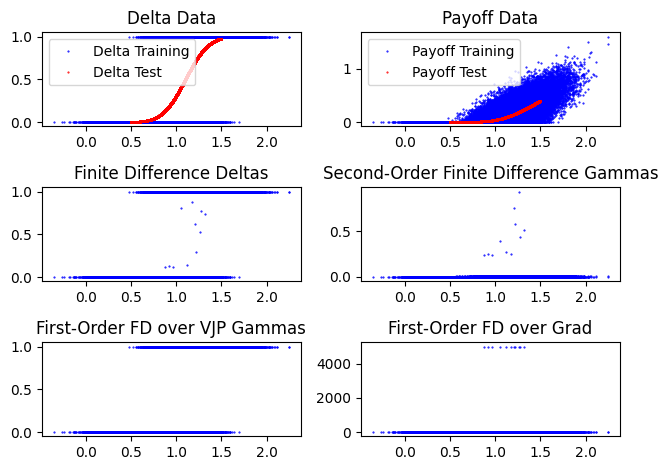

In [9]:

def plot_payoff_data(axs, x_train, y_train, x_test, y_test):
    axs.set_title("Payoff Data")
    axs.plot(x_train, y_train, 'b.', label='Payoff Training', markersize=1)
    axs.plot(x_test, y_test, 'r.', label='Payoff Test', markersize=1)
    axs.legend()

def plot_delta_data(axs, x_train, x_test, dydx_train, dydx_test):
    axs.set_title("Delta Data")
    axs.plot(x_train, dydx_train, 'b.', label='Delta Training', markersize=1)
    axs.plot(x_test, dydx_test, 'r.', label='Delta Test', markersize=1)
    axs.legend()

fig, axs = plt.subplots(3, 2)

Xs = X

plot_payoff_data(axs[0, 1], Xs, Y[:,0], baskets[:, 0], prices[:,0])
plot_delta_data(axs[0, 0], Xs, baskets[:, 0], Z[:,0], deltas[:,0])

axs[1, 0].set_title("Finite Difference Deltas")
axs[1, 0].plot(Xs, Z_fd, 'b.', label='FD', markersize=1)
axs[1, 1].set_title("Second-Order Finite Difference Gammas")
axs[1, 1].plot(Xs, W_fd_of_fd, 'b.', label='FD', markersize=1)
axs[2, 0].set_title("First-Order FD over VJP Gammas")
axs[2, 0].plot(Xs, W_fd_of_vjp, "b.", label='FD', markersize=1)
axs[2, 1].set_title("First-Order FD over Grad")
axs[2, 1].plot(Xs, W_fd_of_grad, "b.", label='FD', markersize=1)

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()


In [10]:
bachelier_params = BachelierParams(n_dim=7, anti=False)
training_set = trainingSet(N_TRAINING_SAMPLES, bachelier_params, seed=42)
X, Y, Z, W, weights, inc1, fd, fdd, jac_fd, fdd_over_grad = astuple(training_set)
test_set = testSet(bachelier_params, training_set, n_samples=N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas = astuple(test_set)
payoff = partial(payoff_fn, a=weights, K=bachelier_params.K)
D_payoff = vmap(grad(payoff))

bkt vol is= 0.20000000298023224
S1.shape (array(8192, dtype=int32), array(7, dtype=int32))
vols is= [0.23430282 0.4360421  0.16845946 0.21118413 0.70081824 0.5712375
 0.78067786]
MSE(Y_vjp, Y) = 0.0
Close(Y_vjp, Y) ? True
Example values: 0.0, 0.0
W_fd_of_fd vs W_fd_of_vjp 0.01003691554069519
MSE(Z_grad, Z_analytic) = 0.0
MSE(Z_vjp, Z_analytic) = 0.0
Close(Z_vjp, Z) ? True
Close(Z_grad, Z) ? True


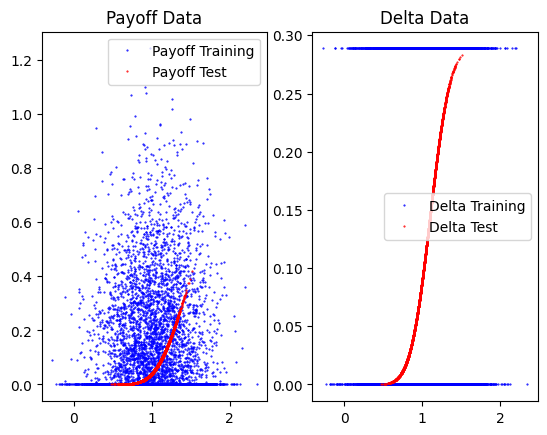

In [11]:
vis_dim = 0
fig, axs = plt.subplots(1, 2)

plot_payoff_data(axs[0], X[:,vis_dim], Y[:,vis_dim], baskets[:, vis_dim], prices[:,vis_dim])
plot_delta_data(axs[1], X[:,vis_dim], baskets[:, vis_dim], Z[:,vis_dim], deltas[:,vis_dim])

plt.show()

## Train Standard ML

In [12]:
@jit
def normalize(data: Array):
    mean = jnp.mean(data)
    std = jnp.std(data)
    return (data - mean) / std, mean, std

# normalize data
x_train, x_train_mean, x_train_std = normalize(X)
y_train, y_train_mean, y_train_std = normalize(Y)
dydx_train, dydx_train_mean, dydx_train_std = normalize(Z)

In [13]:
x_train = X
y_train = Y
dydx_train = Z

In [14]:
# Hyperparameters
# batch_size = 128
# learning_rate = 0.01
num_epochs = NUM_EPOCHS
seed = 42

key = jax.random.PRNGKey(seed)

In [15]:
def x_normalizer(x):
    return (x - x_train_mean) / x_train_std

def y_denormalizer(x):
    return x * y_train_std + y_train_mean

class MLP_Normalized(eqx.Module):
    layers: list

    def __init__(self, key, in_size, out_size):
        key, subkey = jax.random.split(key)
        self.layers = [x_normalizer, 
                       eqx.nn.MLP(key=subkey, in_size=in_size, out_size=out_size, width_size=20, depth=3, activation=jax.nn.elu), 
                       y_denormalizer]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [16]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  # print(out, in_)
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model


In [17]:
def mean_squared_error(y: Float[Array, "n"], pred_y: Float[Array, "n"]) -> Float:
    return jnp.mean((y - pred_y) ** 2)

In [18]:
@jit
def rmse(y: Float[Array, "n"], pred_y: Float[Array, "n"]) -> Float:
    return jnp.sqrt(jnp.mean((y - pred_y) ** 2))

In [19]:
class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())

In [20]:
@eqx.filter_jit
def loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"]) -> Float:
    pred_y = vmap(MakeScalar(model))(x)
    pred_y = pred_y[:, jnp.newaxis]
    result = mean_squared_error(y, pred_y)
    return result

In [21]:
def evaluate(model, testloader):
    """
    This function evaluates the model on the test dataset,
    computing both the average loss.
    """
    avg_loss = 0
    for (x, y, _) in testloader:
        avg_loss += loss_fn(model, x, y)
    return avg_loss / len(testloader)

In [22]:
def train(model: eqx.nn.MLP,
          generator_train_ds,
          generator_test_ds,
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for (batch_x, batch_y, _) in generator_train_ds:

            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y)

        test_loss = evaluate(model, generator_test_ds)
        print('Finished epoch {:3d}'.format(epoch), 
                ' | Train Loss: {:.5f}'.format(train_loss),
                ' | Test Loss: {:.5f}'.format(test_loss))

    return model

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [24]:
key, subkey = jax.random.split(key)
# model = eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

# use linear on-cycle decay scheduler
num_epochs = 100
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
# print(total_steps)
# lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                                  pct_start=0.2, pct_final=0.6,
#                                                                  div_factor=1000., final_div_factor=1.0e4)


lr_schedule = optax.exponential_decay(init_value=0.001, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)

# lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.01)
# lr_schedule = optax.constant_schedule(0.0001)
# lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)

# optim = optax.adam(learning_rate=0.001)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=lr_schedule)
# model = MakeScalar(model)
model = train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)

Finished epoch   0  | Train Loss: 0.01621  | Test Loss: 0.00449
Finished epoch   1  | Train Loss: 0.01694  | Test Loss: 0.00158
Finished epoch   2  | Train Loss: 0.01610  | Test Loss: 0.00127
Finished epoch   3  | Train Loss: 0.01340  | Test Loss: 0.00109
Finished epoch   4  | Train Loss: 0.01267  | Test Loss: 0.00098
Finished epoch   5  | Train Loss: 0.01292  | Test Loss: 0.00085
Finished epoch   6  | Train Loss: 0.01316  | Test Loss: 0.00070
Finished epoch   7  | Train Loss: 0.01333  | Test Loss: 0.00060
Finished epoch   8  | Train Loss: 0.01281  | Test Loss: 0.00051
Finished epoch   9  | Train Loss: 0.01230  | Test Loss: 0.00043
Finished epoch  10  | Train Loss: 0.01243  | Test Loss: 0.00036
Finished epoch  11  | Train Loss: 0.01184  | Test Loss: 0.00030
Finished epoch  12  | Train Loss: 0.01080  | Test Loss: 0.00027
Finished epoch  13  | Train Loss: 0.01183  | Test Loss: 0.00022
Finished epoch  14  | Train Loss: 0.01515  | Test Loss: 0.00020
Finished epoch  15  | Train Loss: 0.0111

In [25]:
class Predictions(eqx.Module):
    y: Array
    dydx: Array
    ddyddx: Array

def predict(model, xs):
    pred_y, pred_dydx = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(xs)
    pred_ddyddx = vmap(jax.hessian(MakeScalar(model)))(xs)

    return Predictions(pred_y, pred_dydx, pred_ddyddx)
    

In [26]:
pred = predict(model, x_test)

## Plot results

RMSE: 0.007332807406783104


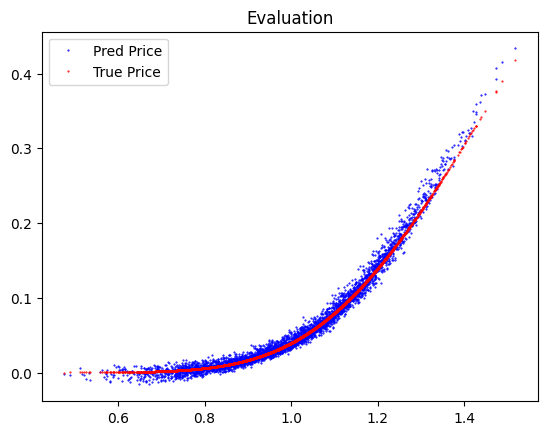

RMSE: 0.013341673649847507


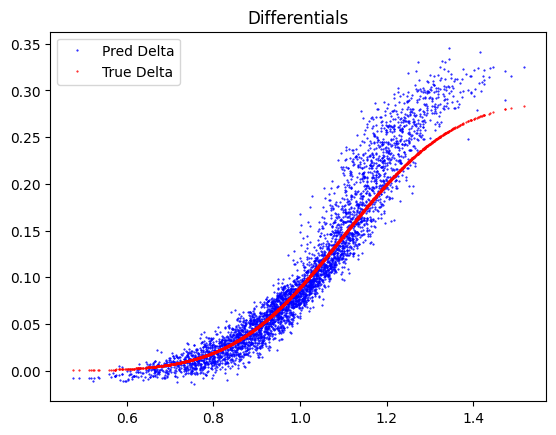

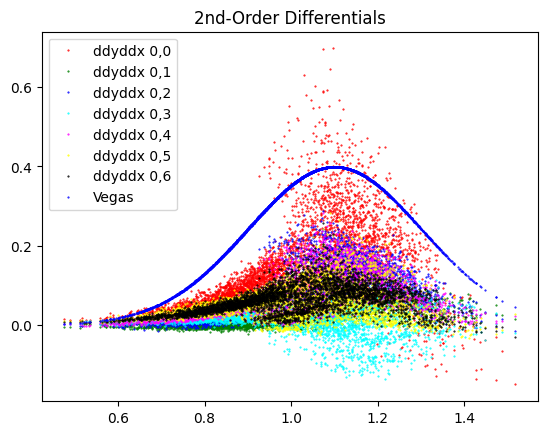

In [27]:
def plot_eval(model, pred: Predictions, test_set: TestSet):

    def print_rmse(pred, true):
        print(f"RMSE: {rmse(true, pred)}")

    x_test, baskets, y_test, dydx_test, vegas = astuple(test_set)
    pred_y, pred_dydx, pred_ddyddx = astuple(pred)
    pred_y = pred_y[:, jnp.newaxis]

    print_rmse(pred_y, y_test)

    plt.title("Evaluation")
    plt.plot(baskets, pred_y, 'b.', markersize=1)
    plt.plot(baskets, y_test, 'r.', markersize=1)
    plt.legend(['Pred Price', 'True Price'], loc='upper left')
    plt.show()

    print_rmse(pred_dydx, dydx_test)

    plt.title("Differentials")
    dydx_idx = 0
    plt.plot(baskets, pred_dydx[:, dydx_idx], 'b.', markersize=1)
    plt.plot(baskets, dydx_test[:, dydx_idx], 'r.', markersize=1)
    plt.legend(['Pred Delta', 'True Delta'], loc='upper left')
    plt.show()

    colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple', 'brown', 'pink', 'gray']
    plt.title("2nd-Order Differentials")
    for i in range(baskets.shape[-1]):
        for j in range(pred_ddyddx.shape[1]):
            plt.plot(baskets, pred_ddyddx[:, i, j], '.', color=colors[j % len(colors)], markersize=1, label=f"ddyddx {i},{j}")

    plt.plot(baskets, vegas, 'b.', markersize=1, label="Vegas")
    plt.legend()
    plt.show()

plot_eval(model, pred, test_set)

## Learning Rate Schedule

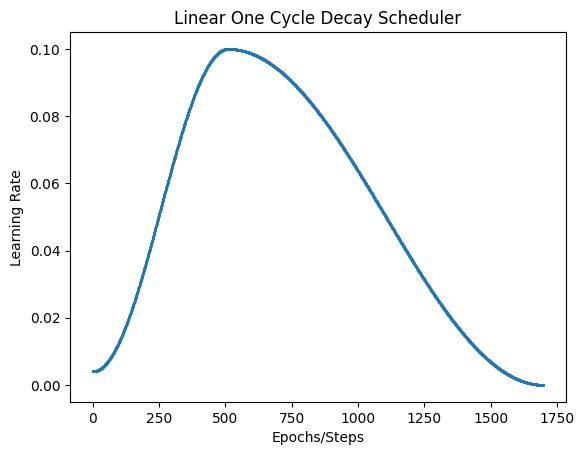

In [28]:

lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
                                                                 pct_start=0.2, pct_final=0.6,
                                                                 div_factor=10., final_div_factor=1.0e6)


lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)

lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.1)

lrs = vmap(lr_schedule)(jnp.arange(total_steps))
plt.scatter(range(total_steps), lrs, s=1)
plt.title("Linear One Cycle Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")
plt.show()

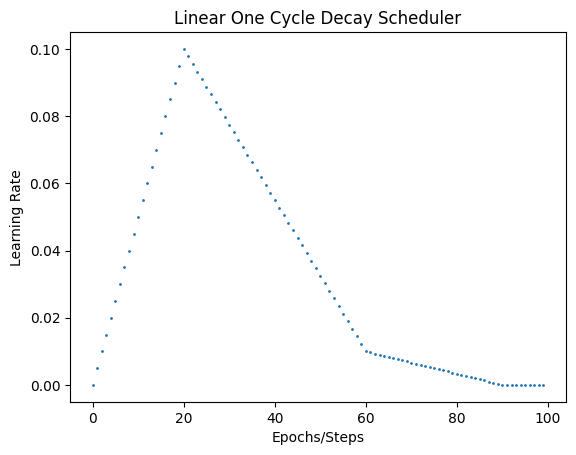

In [29]:
# this is the learning rate used by Savine et al.
lr_data = jnp.array([1e-08, 0.0050000095, 0.010000009, 0.0150000085, 0.020000008000000003, 0.025000007500000004, 0.030000007000000002, 0.03500000650000001, 0.040000006000000005, 0.0450000055, 0.05000000500000001, 0.055000004500000005, 0.060000004, 0.0650000035, 0.070000003, 0.0750000025, 0.080000002, 0.0850000015, 0.090000001, 0.0950000005, 0.1, 0.09775, 0.0955, 0.09325, 0.09100000000000001, 0.08875000000000001, 0.08650000000000001, 0.08425, 0.082, 0.07975000000000002, 0.07750000000000001, 0.07525000000000001, 0.07300000000000001, 0.07075000000000001, 0.0685, 0.06625, 0.064, 0.061750000000000006, 0.059500000000000004, 0.057249999999999995, 0.05499999999999999, 0.052750000000000005, 0.0505, 0.04825, 0.046, 0.04375, 0.041499999999999995, 0.03925000000000001, 0.037000000000000005, 0.03475, 0.0325, 0.03025, 0.027999999999999997, 0.025749999999999995, 0.023499999999999993, 0.02124999999999999, 0.01899999999999999, 0.01675, 0.014499999999999999, 0.012249999999999997, 0.01, 0.0096667, 0.0093334, 0.009000099999999999, 0.008666799999999999, 0.008333499999999999, 0.008000199999999999, 0.007666899999999998, 0.007333599999999997, 0.007000300000000001, 0.006667000000000001, 0.006333700000000001, 0.0060004, 0.0056671000000000004, 0.0053338, 0.0050005, 0.0046672, 0.004333899999999999, 0.004000599999999999, 0.0036672999999999983, 0.0033339999999999984, 0.0030006999999999976, 0.002667400000000001, 0.0023341000000000013, 0.0020008000000000005, 0.0016675000000000006, 0.0013342000000000007, 0.0010009000000000007, 0.0006675999999999991, 0.0003342999999999992, 1e-06, 9.009999999999998e-07, 8.019999999999997e-07, 7.029999999999997e-07, 6.040000000000005e-07, 5.050000000000005e-07, 4.0600000000000033e-07, 3.070000000000002e-07, 2.0800000000000006e-07, 1.0899999999999993e-07])
plt.scatter(range(len(lr_data)), lr_data, s=1)
plt.title("Linear One Cycle Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")
plt.show()

# Differential ML

## Data generation

In [30]:
@eqx.filter_jit
def diff_loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"]) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    # alpha = 0.5
    # beta = 1.0 - alpha
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x)

    y_pred = y_pred[..., jnp.newaxis]
    dydx_pred = dydx_pred
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    value_loss = alpha * jnp.mean((y_pred - y)**2)
    grad_loss = beta * jnp.mean((dydx_pred - dydx)**2)
    loss = value_loss + grad_loss

    # jax.debug.print('[Internal] Value Loss {value_loss} | Grad Loss: {grad_loss}', value_loss=value_loss, grad_loss=grad_loss)
    return loss

In [31]:
def optimal_step(x: Float):
    h = jnp.sqrt(jnp.finfo(jnp.float32).eps)
    return h * jnp.fabs(x)

## Train

In [32]:
def diff_train(model: eqx.nn.MLP,
          generator_train_ds,
          generator_test_ds,
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(diff_loss_fn)(model, x, y, dydx)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for (batch_x, batch_y, batch_dydx) in generator_train_ds:
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y, batch_dydx)

        test_loss = rmse(vmap(model)(x_test), y_test)
        print('Finished epoch {:3d}'.format(epoch), 
                ' | Train Loss: {:.5f}'.format(train_loss),
                ' | Test Loss: {:.5f}'.format(test_loss))

    return model

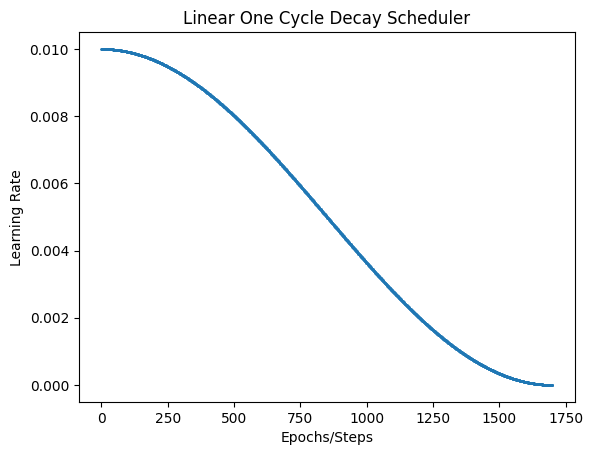

In [33]:
# linear_onecycle_decay_scheduler = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                                  pct_start=0.2, pct_final=0.6,
#                                                                  div_factor=100., final_div_factor=1.0e6)

total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
# lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                 pct_start=0.2, pct_final=0.6,
#                                                 div_factor=100., final_div_factor=1.0e6)

lrs = vmap(lr_schedule)(jnp.arange(total_steps))
plt.scatter(range(total_steps), lrs, s=1)
plt.title("Linear One Cycle Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")
plt.show()

In [34]:
seed = SEED
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [36]:
optim = optax.adam(learning_rate=lr_schedule)
model = diff_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=100)

Finished epoch   0  | Train Loss: 0.00468  | Test Loss: 0.01223
Finished epoch   1  | Train Loss: 0.00447  | Test Loss: 0.00963
Finished epoch   2  | Train Loss: 0.00427  | Test Loss: 0.00431
Finished epoch   3  | Train Loss: 0.00385  | Test Loss: 0.00402
Finished epoch   4  | Train Loss: 0.00381  | Test Loss: 0.00728
Finished epoch   5  | Train Loss: 0.00402  | Test Loss: 0.00486
Finished epoch   6  | Train Loss: 0.00461  | Test Loss: 0.00483
Finished epoch   7  | Train Loss: 0.00451  | Test Loss: 0.00909
Finished epoch   8  | Train Loss: 0.00417  | Test Loss: 0.00797
Finished epoch   9  | Train Loss: 0.00449  | Test Loss: 0.00350
Finished epoch  10  | Train Loss: 0.00442  | Test Loss: 0.00375
Finished epoch  11  | Train Loss: 0.00428  | Test Loss: 0.00657
Finished epoch  12  | Train Loss: 0.00430  | Test Loss: 0.00385
Finished epoch  13  | Train Loss: 0.00415  | Test Loss: 0.00676
Finished epoch  14  | Train Loss: 0.00428  | Test Loss: 0.00372
Finished epoch  15  | Train Loss: 0.0042

## Plot results

RMSE: 0.0030280589126050472


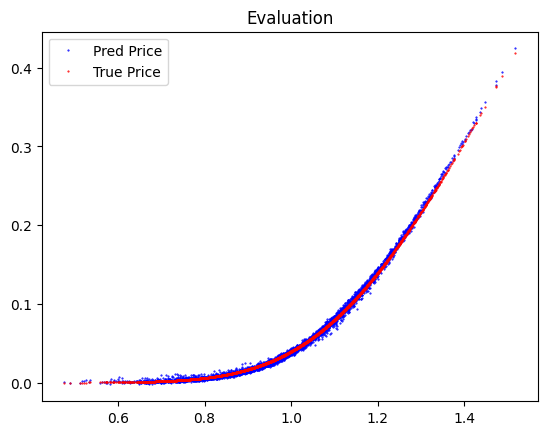

RMSE: 0.006530470214784145


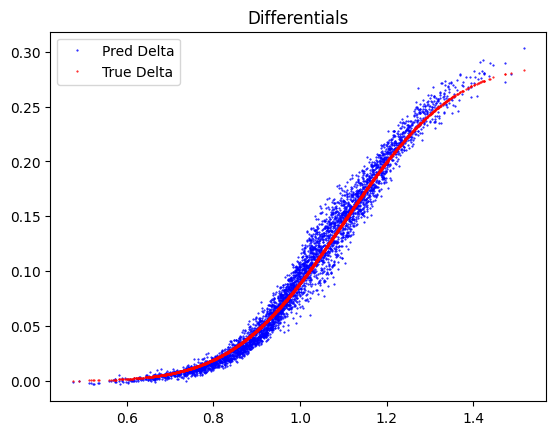

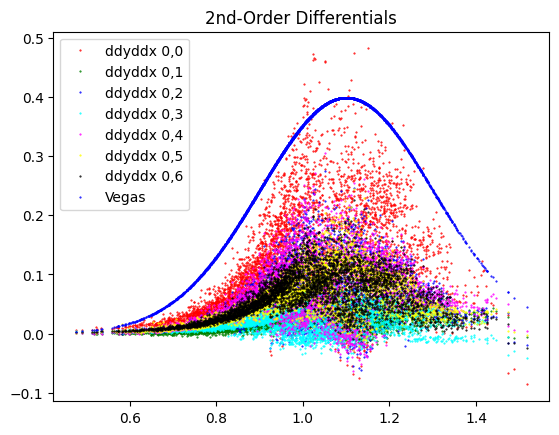

In [37]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

# Differential ML with PCA

## Data generation

In [38]:
def hvp(f, primals, tangents):
    return eqx.filter_jvp(eqx.filter_grad(f), primals, tangents)[1]

def hmp(f, primals):
    
    def hvp_(tangents):
        return hvp(f, (primals,), (tangents, ))

    return eqx.filter_vmap(hvp_)

def batch_hmp(f):

    def hvp_(primals, tangents):
        return hvp(f, (primals,), (tangents,))

    return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1))
    # return eqx.filter_jit(eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1)))

# jax cannot deal with dynamic slices of arrays
# therefore, we cannot simply slice the principal_components array while using batch_hmp

def cond_fn_pca(tangents, *args):
    # xs, cum_sum = x
    # return cum_sum > 0.95

    # jax.debug.print("tangents {tangents}", tangents=tangents)

    return jnp.any(tangents[0] > 0.0)  # NOTE: we set the tangents to zero if we do not want to compute its derivative (because principle component is too small)

def hvp_pca(f, primals, tangents):
    return jax.lax.cond(cond_fn_pca(tangents), lambda _: hvp(f, primals, tangents), lambda _: tangents[0], None)

def batch_hmp_select(f):

    def hvp_(primals, tangents):
        return hvp_pca(f, (primals,), (tangents,))

    # x = jnp.zeros(shape=(1, 1))
    # jax.lax.while_loop(cond_fn_pca, fn, (x, 0.0)) # not reverse-mode differentiable!
    # jnp.piecewise(x, cond_fn_pca, fn, (x, 0.0)) # not reverse-mode differentiable!

    return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1))

In [123]:
from enum import Enum

class dydx_type(Enum):
    Default = 1
    MeanAdjusted = 2
    PCA = 3
    PCA_Reduced = 4


def plot_singular_values(S):
    plt.title("Singular Values of Gradient")
    plt.plot(S, 'r', markersize=0)
    plt.show()


def plot_dydx_pred(x, dydx_pred, title):
   
    if title == dydx_type.Default.value:
        plt.title("Predicted Gradients of all Dimensions")
    elif title == dydx_type.MeanAdjusted.value: 
        plt.title("Predicted Gradients of all Dimensions | Mean Adjusted")
    elif title == dydx_type.PCA.value: 
        plt.title("Predicted Gradients of all Dimensions | PCA reconstruction")
    elif title == dydx_type.PCA_Reduced.value: 
        plt.title("Predicted Gradients of all Dimensions | PCA reduced")
    else:  
        plt.title("Predicted Gradients of all Dimensions")

    for i in range(dydx_pred.shape[1]):
        plt.plot(x[:, i], dydx_pred[:, i], '.', markersize=1)
    plt.show()


def plot_dydx_pred_individual_dims(x, dydx, dydx_pred, dydx_pred_pca, principal_components, pc_scaled):

    for i in range(x.shape[1]):

        plt.title(f"Differentials Dimension {i}")
        plt.plot(x[:, i], dydx[:, i], 'r.', markersize=1, label="True")
        plt.plot(x[:, i], dydx_pred[:, i], 'b.', markersize=1, label="Pred")
        plt.legend()
        plt.show()

        # variance within the dimesions:
        plt.title(f"Variance of Dim {i} (y-axis) w.r.t Dim 0 (x-axis))")
        plt.plot(dydx_pred_pca[:, 0], dydx_pred_pca[:, i], 'b.', markersize=1)


        colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple', 'brown', 'pink', 'gray']
        for j, _ in enumerate(principal_components):
            plt.plot(np.array([0, 0 + pc_scaled[j, 0]]),
                    np.array([0,  0 + pc_scaled[j, i]]), '-',  color=colors[j % len(colors)], linewidth=5, label=f"PC{j}")

        plt.legend()
        plt.show()


# def plot_ddyddx(x, ddyddx):
#   plt.title("Gammas ")
#   dydx_idx = 0
#   for i in range(x_test.shape[1]):
#     for j in range(x_test.shape[1]):
#       plt.plot(baskets, pred_ddyddx[:, i, j], '.', markersize=1, label=f"Gamma {i},{j}")
#   plt.legend(loc='upper left')
#   plt.show()

colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple', 'brown', 'pink', 'gray']

def plot_ddyddx_pred(x, ddyddx):
  for i in range(x.shape[1]):
    plt.title(f"2nd-Order Differential Predictions {i}")

    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j % len(colors)], label=f"ddyddx {i},{j}")
    plt.show()


def plot_ddyddx_pred_hvp(x, ddyddx):
  plt.title(f"2nd-Order Differential HVP Predictions")
  for i in range(x.shape[1]):
    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")
  plt.show()

def plot_ddyddx_fd(x, ddyddx):
  plt.title(f"2nd-Order Finite-Difference Predictions")
  for i in range(x.shape[1]):
    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")
  plt.show()

def plot_ddyddx_fd_of_grad(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over Grad Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()

def plot_ddyddx_fd_of_grad_full(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over Grad Full Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()

def plot_ddyddx_fd_of_fd(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over FD Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()


def plot_hesse_model_vs_data(x, hesse_model, hesse_data):
  plt.title(f"Hesse Model vs Data")

  # for now we only consider one dimension
  for i in range(x.shape[-1]):
    lines_x = jnp.array([x[:, i], x[:, i]])
    lines_y = jnp.array([hesse_model[:, i, 0], hesse_data[:, i, 0]])
    plt.plot(lines_x, lines_y, c='lightgray')
    plt.plot(x[:, i], hesse_model[:, i, 0], '.', c='blue', markersize=3, label=f"hesse model")
    plt.plot(x[:, i], hesse_data[:, i, 0], '.', c='red', markersize=3, label=f"hesse data")
  plt.show()


def plot_ddyddx_pred_all(x, selected_hvp, hessian_data, hessian, fd_of_grad_full, n_dims):
  titles = ['pc @ hessian (model)', 'hesse vectors (data)', 'hessian (model)', 'fd of grad (model)']

  fig, axs = plt.subplots(2, 2)

  def get_axes_coordinates(i):
      x = i // 2
      y = i % 2
      return (x, y)

  for k, ddyddx in enumerate([selected_hvp, hessian_data, hessian, fd_of_grad_full]):
    for i in range(x.shape[-1]):
      for j in range(ddyddx.shape[1]):
        ax = get_axes_coordinates(k)
        a = axs[ax[0], ax[1]]
        a.set_title(titles[k])
        a.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()


def plot_ddyddx_pred_hess_compare(x, selected_hvp, hessian_data, hessian, fd_of_grad_full, n_dims):
  titles = ['selected_hvp', 'hmp_pc', 'hmp_res', 'hessian']

  fig, axs = plt.subplots(2, 2)

  def get_axes_coordinates(i):
      x = i // 2
      y = i % 2
      return (x, y)

  for k, ddyddx in enumerate([selected_hvp, hessian_data, hessian, fd_of_grad_full]):
    for i in range(x.shape[-1]):
      for j in range(ddyddx.shape[1]):
        ax = get_axes_coordinates(k)
        a = axs[ax[0], ax[1]]
        a.set_title(titles[k])
        a.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()




def plot_batch(x, y, y_pred):
    plt.title("Data Batch Normalized")
    plt.plot(x, y, 'r.', markersize=1)
    plt.plot(x, y_pred, 'b.', markersize=1)
    plt.show()


def plot_batch_delta(x, y_delta):
    plt.title("Data Batch Delta")
    plt.plot(x, y_delta, 'b.', markersize=1)
    plt.show()


def print_ddpayoff(ddpayoff):
    nnz = ddpayoff != 0.
    ddpayoff_nnz = ddpayoff[nnz]
    print("ddpayoff: ", ddpayoff_nnz) #.reshape(-1, ddpayoff.shape[-1]))

  
def print_k_pc(pc, k_pc):
  print("pc: ", pc[k_pc:, :])


def diff_pca_loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], inc1: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"], debug: bool = True) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    alpha = 0.2
    gamma = 0.2 # NOTE: we could use the magnitue of the principle components to set this value
    beta = 1.0 - alpha - gamma
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x)

    # for now we instantiate the full hessian matrix
    hess = jax.hessian(MakeScalar(model))
    hessian = eqx.filter_vmap(hess)(x)
    # jax.debug.print("Hessian: {H}", H=hessian.shape)

    # do a hessian with custom batch_hmp
    batch_hmp_fn = batch_hmp(MakeScalar(model))
    basis = jnp.eye(x.shape[-1], dtype=x.dtype)
    hmp_res = batch_hmp_fn(x, basis)
    hmp_res = jnp.transpose(hmp_res, (1, 0, 2))

    y_pred = y_pred[..., jnp.newaxis]
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)

    if 1:
      dydx_pred_means = jnp.mean(dydx_pred, axis=0)
      # print("dydx_pred_means.shape:", dydx_pred_means.shape)
      # print("dydx_pred_means: ", dydx_pred_means)

      dydx_pred_mean_adjusted = dydx_pred - jnp.tile(dydx_pred_means, (dydx_pred.shape[0], 1))

      U, S, VT = jnp.linalg.svd(dydx_pred_mean_adjusted, full_matrices=False)
    else:
      # Alternative approach: Use the difference of dydx_pred and dydx to get the principle components
      dydx_diff = dydx_pred - dydx
      dydx_pred_means = jnp.mean(dydx_diff, axis=0)
      dydx_pred_mean_adjusted = dydx_diff - jnp.tile(dydx_pred_means, (dydx_diff.shape[0], 1))
      U, S, VT = jnp.linalg.svd(dydx_pred_mean_adjusted, full_matrices=False)

    # the principal components give use the directions for the hesse vectors
    principal_components = jnp.diag(S) @ VT

    if debug:
      jax.debug.print("Singluar Values: {S}", S=S)
      S_var = S**2 / jnp.sum(S**2)

      jax.debug.print("Singluar Values Variance Explained: {S}", S=S_var)
      # find index k, s.t. the first k elements in S_var account for 95% of the variance
      k_pc = np.argmax(np.cumsum(S_var) > 0.95) # returns first occurence of True
      jax.debug.print("k_pc: {k_pc}", k_pc=k_pc)
      # jax.debug.print("k_pc.dtype: {k_pc}", k_pc=k_pc.dtype)


      # jax.debug.print("pc.shape[0]: {pc}", pc=principal_components.shape[0])

      # first_k_pc = jax.lax.dynamic_slice_in_dim(principal_components, 0, k_pc, axis=0)
      # first_k_pc = jax.lax.dynamic_slice_in_dim(principal_components, 0, k_pc, axis=0)
      # first_k_pc = jax.lax.dynamic_slice(principal_components, (0, 0), (2, 2))

      jax.debug.print("pc {pc}", pc=principal_components)
      # jax.debug.print("first k pc {pc}", pc=principal_components[:k_pc, :])
      # print("first k pc: ", first_k_pc)

      # hvp_first_k_pc = principal_components[:2, :] @ hessian
      # jax.debug.print("hvp_first_k_pc {hvp}", hvp=hvp_first_k_pc)

    # NOTE: The principle component directions could have a factor -1 that deviates from the desired direction (e.g., vector points north instead of south in 2D case).
    #       We need to check for that and flip the sign of the principle component if necessary.
    #       This can be decided using the dydx target data.
    #       -> not an issue if we consider pc @ hessian

    # TODO: Think about the implications and whether to do this per dimension or per batch
    #       For now we do it per dimension



    # now instead of computing the hessian seperately from the identity matrix
    # we directly use the principle components

    # jax.debug.print("basis.shape {basis}", basis=basis.shape)
    # jax.debug.print("principal_components.shape {pc}", pc=principal_components.shape)
    hmp_pc = batch_hmp_fn(x, principal_components.T)
    hmp_pc = jnp.transpose(hmp_pc, (1, 0, 2))


    hmp_pc2 = batch_hmp_fn(x, principal_components[:2, :].T)
    hmp_pc2 = jnp.transpose(hmp_pc2, (1, 0, 2))

    

    # jax.debug.print("pc2 {pc}", pc=principal_components[:2, :])

    # direction_signs = jnp.sign(jnp.sum(dydx * principal_components, axis=1))


    # we need the vjp_fun from eqx.filter_vjp 
    # then we can *hopefully* use eqx.filter_vjp(vjp_fun, principal_components) 
    # to get to selected hvp results. Those can then be used as part of the loss  

    partial_vjp = partial(eqx.filter_vjp, MakeScalar(model))
    y_pred_vjp, vjp_fun = vmap(partial_vjp)(x)

    # jax.debug.print("function is: {fn}", fn=vjp_fun)
    # test_values = vmap(vjp_fun)(jnp.ones_like(y_pred_vjp))
    # jax.debug.print("test values = {tv}", tv=test_values)

    y_pred_vjp = y_pred_vjp[..., jnp.newaxis]

    # jax.debug.print("y_pred={y}", y=y_pred)
    # jax.debug.print("y_pred_vjp={y}", y=y_pred_vjp)
    # jax.debug.print("MSE(y_pred, y_pred_vjp) = {res}", res=mean_squared_error(y_pred, y_pred_vjp))
    # chex.assert_trees_all_close(y_pred, y_pred_vjp)


    # jax.debug.print("shape must be: {shape}", shape=y_pred_vjp.shape)
    # jax.debug.print("but we have: {shape}", shape=x.shape)
    # dydx_pred_vjp, hvp_fun = vmap(partial(eqx.filter_vjp, vjp_fun))(x)


    # basis = jnp.eye(y_pred_vjp.size, dtype=y.dtype)
    # jac = vmap(vjp_fun)(basis)[0] 

    # ---

    # jax.debug.print("Hessian shape {H}", H=hessian.shape)
    # jax.debug.print("Principle components shape: {PC}", PC=principal_components.shape)

    # generate the missing second-order differential training data which 
    # depends on the principle components.

    # Y, Z_grad = jax.vmap(jax.value_and_grad(payoff, argnums=0))(S1, inc1)

    D_payoff = jax.vmap(jax.grad(payoff))

    def cfd(f, h, x, *args):

      def cfd_(v):
        xph = x + h * v 
        xmh = x - h * v 
        fd_of_f = (f(xph, *args) - f(xmh, *args)) / (2 * h)
        # jax.debug.print("fd_of_f = {fd}", fd=fd_of_f)

        # fd_of_f = vmap(jnp.multiply)(fd_of_f, jnp.sign(v))
        # fd_of_f = jnp.multiply(fd_of_f, jnp.sign(v))
        # jax.debug.print("fd_of_f_after = {fd}", fd=fd_of_f)

        # jax.debug.print("shape of v: {v}", v=v.shape)
        # jax.debug.print("fd_of_f.shape: {fd}", fd=fd_of_f.shape)
        return fd_of_f

      return cfd_

    def optimal_step(x: Float):
        h = jnp.sqrt(jnp.finfo(jnp.float32).eps)
        return h * jnp.fabs(x)

    # for now consider fixed h
    # h = optimal_step(jnp.mean(x))
    # h = 5e-2
    h = 1e-1
    # h = 1.
    # jax.debug.print("h = {h}", h=h)
    eye = jnp.eye(n_dims)
    basis = eye * h
    v = principal_components[0] 
    # jax.debug.print("v : {v}", v=v)

    # jax.debug.print("x : {x}", x=x)

    xph = x + h * v
    # jax.debug.print("xph : {xph}", xph=xph)
    xmh = x - h * v
    # jax.debug.print("xmh : {xmh}", xmh=xmh)

    fd_xph = D_payoff(xph, inc1)
    # jax.debug.print("fd_xph : {fd}", fd=fd_xph)
    fd_xmh = D_payoff(xmh, inc1)
    # jax.debug.print("fd_xmh : {fd}", fd=fd_xmh)
    fd_of_dpayoff = (D_payoff(xph, inc1) - D_payoff(xmh, inc1)) / (2 * h)
    # jax.debug.print("fd of payoff: {fd}", fd=fd_of_dpayoff)
    # jax.debug.print("mean of fd of payoff: {fd}", fd=jnp.mean(fd_of_dpayoff, axis=0))
    # jax.debug.print("fd of payoff: {fd}", fd=fd_of_dpayoff)

    cfd_of_dpayoff = vmap(cfd(D_payoff, h, x, inc1))
    ddpayoff = cfd_of_dpayoff(principal_components)

    ddpayoff = jnp.transpose(ddpayoff, (1, 0, 2))
    # ddpayoff = jnp.abs(ddpayoff)

    # jax.debug.print("shape of ddpayoff: {ddp}", ddp=ddpayoff.shape)
    # jax.debug.print("ddpayoff: {fd}", fd=ddpayoff)

    # jax.debug.print("-" * 40)
    # jax.debug.print("principal components: {pc}", pc=principal_components)
    # jax.debug.print("first principal components: {pc}", pc=principal_components[0])

    selected_hvp = principal_components @ hmp_res #hessian
    if debug:
      jax.debug.print("Selected HVP shape: {hvp}", hvp=selected_hvp.shape)
      # jax.debug.print("Selcted HVP: {hvp}", hvp=selected_hvp)

      # compute second order central finite differences of model
      h = 1e-4
      fdd_x = x
      grad_model = vmap(eqx.filter_grad(MakeScalar(model)))

      # here we directly perturbe all values of fdd_x. I think we need to do
      # this on a per element basis
      xph = fdd_x + h
      xmh = fdd_x - h
      fdd_xph = grad_model(xph)
      fdd_xmh = grad_model(xmh)
      fd_of_grad = (fdd_xph - fdd_xmh) / (2 * h)

      fd_of_fd_xph = vmap(model)(xph)
      fd_of_fd_xmh = vmap(model)(xmh)
      fd_of_fd = (fd_of_fd_xph - 2 * y_pred + fd_of_fd_xmh) / (h * h)

      def fd_row(i):
          xph = fdd_x.at[:, i].set(fdd_x[:, i] + h)
          xmh = fdd_x.at[:, i].set(fdd_x[:, i] - h)
  
          fdd_xph = grad_model(xph)
          fdd_xmh = grad_model(xmh)
          fdd_i = (fdd_xph - fdd_xmh) / (2 * h) 
          return fdd_i

      fd_of_grad_full = jnp.transpose(jnp.array([fd_row(i) for i in range(x.shape[-1])]), (1, 0, 2))

      hessian_data = jnp.zeros_like(hessian)
      jax.debug.print("FD_of_grad shape: {fd}", fd=fd_of_grad.shape)
      jax.debug.print("FD_of_grad_full shape: {fd}", fd=fd_of_grad_full.shape)
      jax.debug.print("FD_of_FD shape: {fd}", fd=fd_of_fd.shape)
      jax.debug.print("hessian shape: {fd}", fd=hessian.shape)

      pc_scaled = principal_components / jnp.sqrt(x.shape[0])
      dydx_pred_pca = U @ principal_components
      k_dims = 1
      dydx_pred_reduced = U[:, :k_dims] @ principal_components[:k_dims, :]

      pca_reconstruction_err = mean_squared_error(dydx_pred_mean_adjusted, dydx_pred_pca)
      jax.debug.print("pca reconstruction_err: {err}", err=pca_reconstruction_err)

      reduced_reconstruction_err = mean_squared_error(dydx_pred_mean_adjusted, dydx_pred_reduced)
      jax.debug.print("reduced ({dim} dims) reconstruction_err: {err}", dim=k_dims, err=reduced_reconstruction_err)

      # TODO: Still need to figure out how to use chex in the context of a jitted eqx function
      # chex.assert_trees_all_close(dydx_pred_pca, dydx_pred_mean_adjusted)

      # print("sanity checks")
      I = jnp.eye(VT.shape[0], U.shape[1])
      UU = U.T @ U
      # print("U.T @ U = ", UU)
      # print("shapes: I: ", I.shape)
      # print("shapes: UU: ", UU.shape)

      # chex.assert_trees_all_close(UU, I)

      chex.assert_rank(UU, 2)
      chex.assert_rank(VT, 2)

      chex.assert_shape(UU, I.shape)
      chex.assert_shape(VT, I.shape)
      # chex.assert_shape(UU.shape, I.shape)
      # assert(jnp.allclose(UU, I, atol=1e-06))
      VV = VT @ VT.T
      # print("V.T @ V = ", VV)
      chex.assert_shape(VV, I.shape)

      # jax.debug.print("VT: {VT}", VT=VT)
      # jax.debug.print("Principle Components: {pc}", pc=pc_scaled)

      # result_shape = jax.ShapeDtypeStruct(S.shape, S.dtype)
      # jax.pure_callback(plot_singular_values, result_shape, S)

      # jax.debug.callback(plot_singular_values, S)

      # jax.debug.callback(plot_dydx_pred, x, dydx_pred, dydx_type.Default.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.MeanAdjusted.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.PCA.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.PCA_Reduced.value)
      # jax.debug.callback(plot_dydx_pred_individual_dims, x, dydx, dydx_pred, dydx_pred_pca, principal_components, pc_scaled)

      # jax.debug.callback(plot_ddyddx_pred, x, selected_hvp)
      
      # jax.debug.callback(plot_ddyddx_pred_hvp, x, selected_hvp)
      # jax.debug.callback(plot_ddyddx_fd, x, fdd)
      # jax.debug.callback(plot_ddyddx_fd_of_grad, x, fd_of_grad)
      # jax.debug.callback(plot_ddyddx_fd_of_grad_full, x, fd_of_grad_full)
      # jax.debug.callback(plot_ddyddx_fd_of_fd, x, fd_of_fd)

      # jax.debug.print("Close(Hessian, FD_of_Grad) ? {res}", res=jnp.allclose(hessian, fd_of_grad_full))

      jax.debug.callback(plot_ddyddx_pred_all, x, selected_hvp, ddpayoff, hessian, fd_of_grad_full, x.shape[-1])
      jax.debug.callback(plot_ddyddx_pred_hess_compare, x, selected_hvp, hmp_pc, hmp_res, hessian, x.shape[-1])
      # jax.debug.callback(plot_ddyddx_pred_all, x, selected_hvp, ddpayoff, hmp_pc, hessian, x.shape[-1])
      # jax.debug.callback(plot_hesse_model_vs_data, x, selected_hvp, ddpayoff)

      # jax.debug.print("Close(Hessian, FD_of_Grad) ? {res}", res=mean_squared_error(hessian, fd_of_grad_full))
      # jax.debug.print("Principle Components: {pc}", pc=principal_components)
      # jax.debug.print("ddpayoff.shape = {shape}", shape=ddpayoff.shape)

      # jax.debug.callback(plot_batch, x, y, y_pred)
      # jax.debug.callback(plot_batch_delta, x, y - y_pred)


      # chex.assert_trees_all_close(UU, I)
      # jax.experimental.checkify.check(jnp.allclose(UU, I, atol=1e-6), "Identity not fulfilled")

      # identities(UU, I)
      # print("S = ", S)
      # print("Pc.shape: ", pc_scaled.shape)
      # print("Principle components")

      # plt.title("Singular Values of Gradient")
      # plt.plot(S, 'r', markersize=0)
      # plt.show()

    value_loss = alpha * jnp.mean((y_pred - y)**2)
    grad_loss = beta * jnp.mean((dydx_pred - dydx)**2)
    # hessian_loss = gamma * jnp.mean((selected_hvp - ddpayoff)**2)
    hessian_loss = gamma * jnp.mean((hmp_pc - ddpayoff)**2)
    # hessian_loss = gamma * jnp.mean((hessian - ddpayoff)**2)

    # if not debug: 
    # jax.debug.print('[Internal] Value Loss {value_loss} | Grad Loss: {grad_loss} | Hessian Loss: {hessian_loss}', value_loss=value_loss, grad_loss=grad_loss, hessian_loss=hessian_loss)
    loss = value_loss + grad_loss + hessian_loss
    return loss


## Train

In [124]:
def dd_train(model: eqx.nn.MLP,
          generator_train_ds,
          generator_test_ds,
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS,
          debug: bool = False
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   inc1: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"],
                   debug: bool = False
                   ):
        loss_value, grads = eqx.filter_value_and_grad(diff_pca_loss_fn)(model, x, inc1, y, dydx, debug=debug)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for (batch_x, batch_inc, batch_y, batch_dydx) in generator_train_ds:
            # TODO: split of data can happen in train_step, just use *data
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_inc, batch_y, batch_dydx, debug=debug)

        test_loss = jnp.sqrt(mean_squared_error(vmap(model)(x_test), y_test))
        print('Finished epoch {:3d}'.format(epoch), 
            ' | Train Loss: {:.6f}'.format(train_loss),
            ' | Test Loss: {:.6f}'.format(test_loss))

    return model

In [125]:
# NOTE: additional inc1 is needed to reconstruct the payoff for the second-order derivatives
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, inc1, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [129]:
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

num_epochs = 100
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
# learning_rate=LEARNING_RATE
optim = optax.adam(learning_rate=lr_schedule)
model = dd_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs, debug=False)
# model = dd_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=10, debug=True)

Finished epoch   0  | Train Loss: 0.008636  | Test Loss: 0.033305
Finished epoch   1  | Train Loss: 0.007696  | Test Loss: 0.007447
Finished epoch   2  | Train Loss: 0.007513  | Test Loss: 0.008791
Finished epoch   3  | Train Loss: 0.007134  | Test Loss: 0.006140
Finished epoch   4  | Train Loss: 0.007974  | Test Loss: 0.005494
Finished epoch   5  | Train Loss: 0.007081  | Test Loss: 0.010692
Finished epoch   6  | Train Loss: 0.007521  | Test Loss: 0.009111
Finished epoch   7  | Train Loss: 0.006957  | Test Loss: 0.009571
Finished epoch   8  | Train Loss: 0.007892  | Test Loss: 0.005128
Finished epoch   9  | Train Loss: 0.007361  | Test Loss: 0.005054
Finished epoch  10  | Train Loss: 0.007330  | Test Loss: 0.003151
Finished epoch  11  | Train Loss: 0.007497  | Test Loss: 0.006920
Finished epoch  12  | Train Loss: 0.007671  | Test Loss: 0.003951
Finished epoch  13  | Train Loss: 0.007719  | Test Loss: 0.011082
Finished epoch  14  | Train Loss: 0.007265  | Test Loss: 0.002941
Finished e

## Plot results

RMSE: 0.0019780686125159264


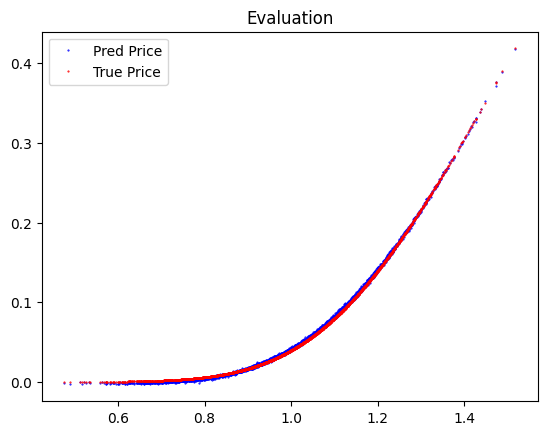

RMSE: 0.002874760190024972


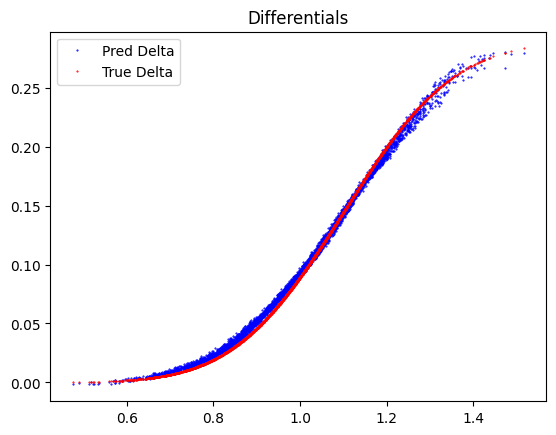

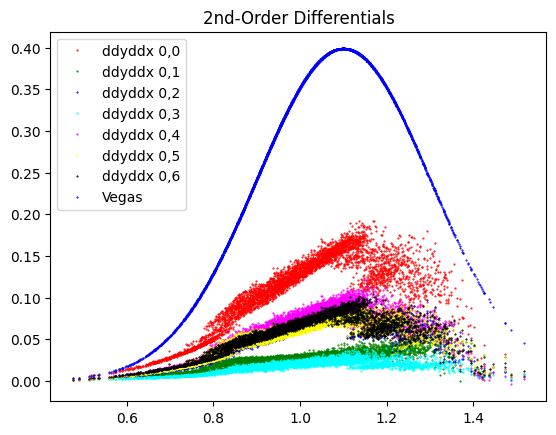

In [130]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

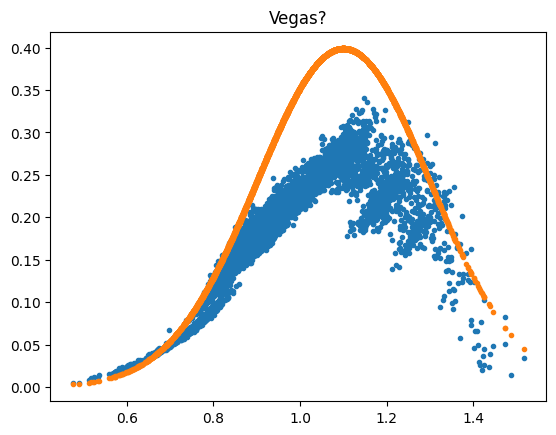

In [131]:
res = jnp.mean(jnp.sum(pred.ddyddx, axis=1), axis=1)

plt.title("Vegas?")
plt.plot(baskets, res, '.')
plt.plot(baskets, vegas, '.')
plt.show()

# Higher-Dimensional Example

In [160]:
bachelier_params = BachelierParams(n_dim=15, anti=True)
training_set = trainingSet(2*N_TRAINING_SAMPLES, bachelier_params, seed=SEED)
X, Y, Z, W, weights, inc1, fd, fdd, jac_fd, fdd_over_grad = astuple(training_set)
test_set = testSet(bachelier_params, training_set, n_samples=2*N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas = astuple(test_set)
payoff = partial(payoff_fn, a=weights, K=bachelier_params.K)
D_payoff = vmap(grad(payoff))

bkt vol is= 0.20000000298023224
S1.shape (array(16384, dtype=int32), array(15, dtype=int32))
vols is= [0.7471553  0.4909427  0.83755344 1.0836253  0.40111983 0.8873838
 0.1662211  0.24636902 0.62629026 0.30487788 0.83382034 1.176383
 0.61544436 0.4292396  1.0516179 ]
MSE(Y_vjp, Y) = 0.0
Close(Y_vjp, Y) ? True
Example values: 0.04847322031855583, 0.04847322031855583
W_fd_of_fd vs W_fd_of_vjp 0.0015871537616476417
MSE(Z_grad, Z_analytic) = 0.0
MSE(Z_vjp, Z_analytic) = 0.0
Close(Z_vjp, Z) ? True
Close(Z_grad, Z) ? True


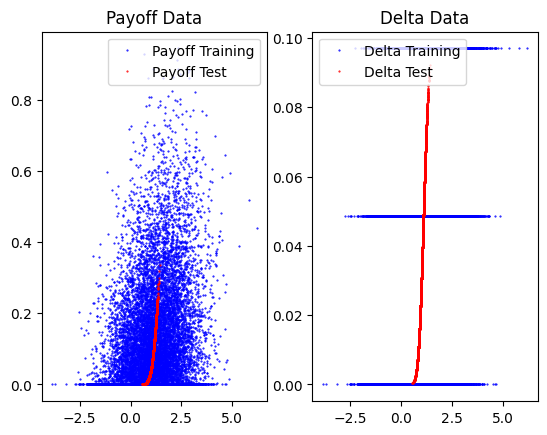

In [161]:
vis_dim = 0
fig, axs = plt.subplots(1, 2)

plot_payoff_data(axs[0], X[:,vis_dim], Y[:,vis_dim], baskets[:, vis_dim], prices[:,vis_dim])
plot_delta_data(axs[1], X[:,vis_dim], baskets[:, vis_dim], Z[:,vis_dim], deltas[:,vis_dim])

plt.show()

In [162]:
x_train, y_train, dydx_train = X, Y, Z

In [163]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

## Standard ML

In [164]:
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key)
# model = eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

# use linear on-cycle decay scheduler
num_epochs = 100
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
# print(total_steps)
# lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                                  pct_start=0.2, pct_final=0.6,
#                                                                  div_factor=1000., final_div_factor=1.0e4)


lr_schedule = optax.exponential_decay(init_value=0.001, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)

# lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.01)
# lr_schedule = optax.constant_schedule(0.0001)
# lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)

# optim = optax.adam(learning_rate=0.001)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=lr_schedule)
# model = MakeScalar(model)
model = train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)

Finished epoch   0  | Train Loss: 0.00879  | Test Loss: 0.00290
Finished epoch   1  | Train Loss: 0.00619  | Test Loss: 0.00195
Finished epoch   2  | Train Loss: 0.00431  | Test Loss: 0.00105
Finished epoch   3  | Train Loss: 0.00331  | Test Loss: 0.00082
Finished epoch   4  | Train Loss: 0.00252  | Test Loss: 0.00065
Finished epoch   5  | Train Loss: 0.00236  | Test Loss: 0.00053
Finished epoch   6  | Train Loss: 0.00185  | Test Loss: 0.00041
Finished epoch   7  | Train Loss: 0.00184  | Test Loss: 0.00033
Finished epoch   8  | Train Loss: 0.00198  | Test Loss: 0.00026
Finished epoch   9  | Train Loss: 0.00180  | Test Loss: 0.00022
Finished epoch  10  | Train Loss: 0.00171  | Test Loss: 0.00019
Finished epoch  11  | Train Loss: 0.00194  | Test Loss: 0.00016
Finished epoch  12  | Train Loss: 0.00207  | Test Loss: 0.00014
Finished epoch  13  | Train Loss: 0.00144  | Test Loss: 0.00013
Finished epoch  14  | Train Loss: 0.00154  | Test Loss: 0.00012
Finished epoch  15  | Train Loss: 0.0017

RMSE: 0.0036438959650695324


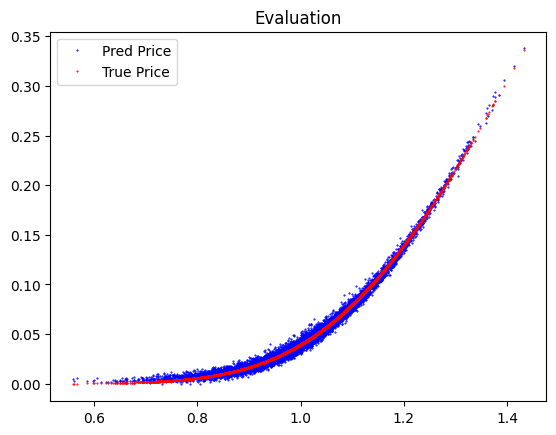

RMSE: 0.0034790753852576017


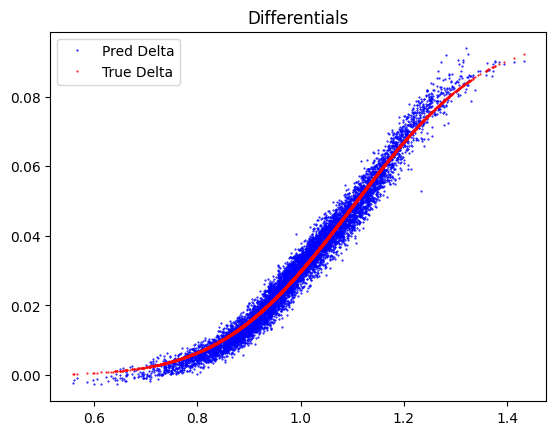

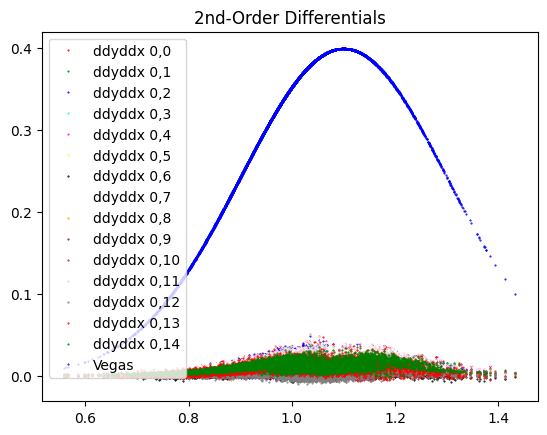

In [165]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

## Differential ML

In [166]:
seed = SEED
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

In [167]:
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
optim = optax.adam(learning_rate=lr_schedule)
model = diff_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)

Finished epoch   0  | Train Loss: 0.00039  | Test Loss: 0.01647
Finished epoch   1  | Train Loss: 0.00030  | Test Loss: 0.00655
Finished epoch   2  | Train Loss: 0.00028  | Test Loss: 0.00484
Finished epoch   3  | Train Loss: 0.00027  | Test Loss: 0.00340
Finished epoch   4  | Train Loss: 0.00025  | Test Loss: 0.00341
Finished epoch   5  | Train Loss: 0.00026  | Test Loss: 0.00224
Finished epoch   6  | Train Loss: 0.00024  | Test Loss: 0.00184
Finished epoch   7  | Train Loss: 0.00025  | Test Loss: 0.00187
Finished epoch   8  | Train Loss: 0.00023  | Test Loss: 0.00273
Finished epoch   9  | Train Loss: 0.00025  | Test Loss: 0.00303
Finished epoch  10  | Train Loss: 0.00025  | Test Loss: 0.00271
Finished epoch  11  | Train Loss: 0.00026  | Test Loss: 0.00204
Finished epoch  12  | Train Loss: 0.00025  | Test Loss: 0.00157
Finished epoch  13  | Train Loss: 0.00027  | Test Loss: 0.00174
Finished epoch  14  | Train Loss: 0.00027  | Test Loss: 0.00196
Finished epoch  15  | Train Loss: 0.0002

RMSE: 0.0012901059817522764


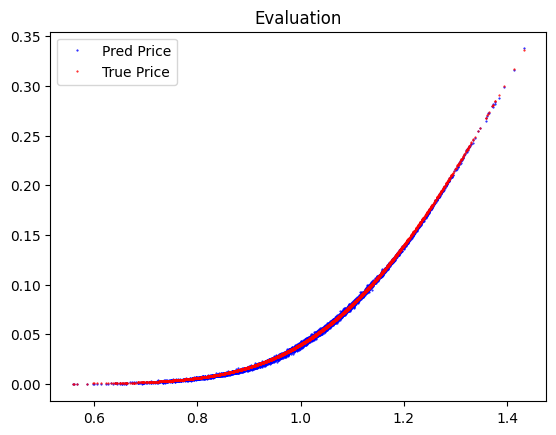

RMSE: 0.0014239504234865308


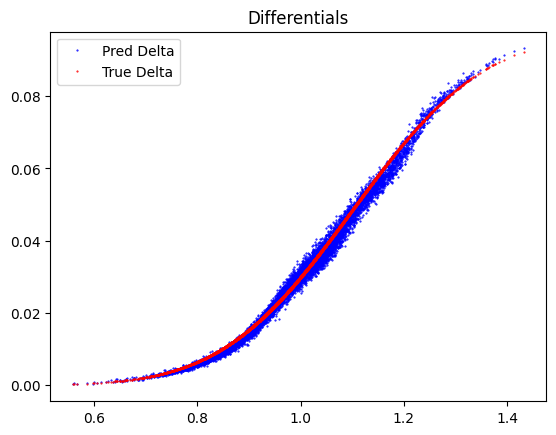

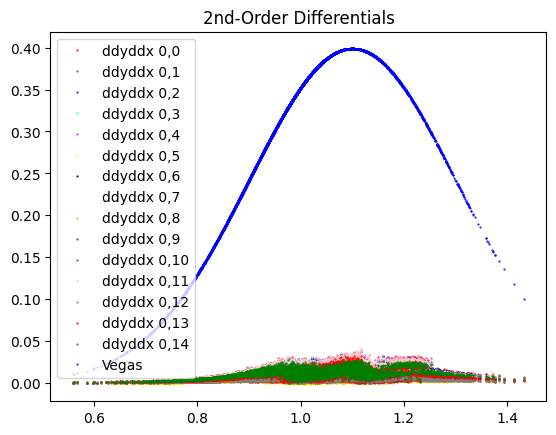

In [169]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

## Second-Order Differential ML

In [201]:
# NOTE: additional inc1 is needed to reconstruct the payoff for the second-order derivatives
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, inc1, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [202]:
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

num_epochs = NUM_EPOCHS

total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
# learning_rate=LEARNING_RATE
optim = optax.adam(learning_rate=lr_schedule)
model = dd_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs, debug=False)

Finished epoch   0  | Train Loss: 0.000740  | Test Loss: 0.012584
Finished epoch   1  | Train Loss: 0.000626  | Test Loss: 0.007903
Finished epoch   2  | Train Loss: 0.000598  | Test Loss: 0.005887
Finished epoch   3  | Train Loss: 0.000598  | Test Loss: 0.003950
Finished epoch   4  | Train Loss: 0.000669  | Test Loss: 0.003560
Finished epoch   5  | Train Loss: 0.000635  | Test Loss: 0.003465
Finished epoch   6  | Train Loss: 0.000528  | Test Loss: 0.003093
Finished epoch   7  | Train Loss: 0.000640  | Test Loss: 0.003144
Finished epoch   8  | Train Loss: 0.000581  | Test Loss: 0.002779
Finished epoch   9  | Train Loss: 0.000635  | Test Loss: 0.002598
Finished epoch  10  | Train Loss: 0.000557  | Test Loss: 0.003066
Finished epoch  11  | Train Loss: 0.000642  | Test Loss: 0.002504
Finished epoch  12  | Train Loss: 0.000757  | Test Loss: 0.002857
Finished epoch  13  | Train Loss: 0.000542  | Test Loss: 0.002787
Finished epoch  14  | Train Loss: 0.000559  | Test Loss: 0.003447
Finished e

RMSE: 0.001496574841439724


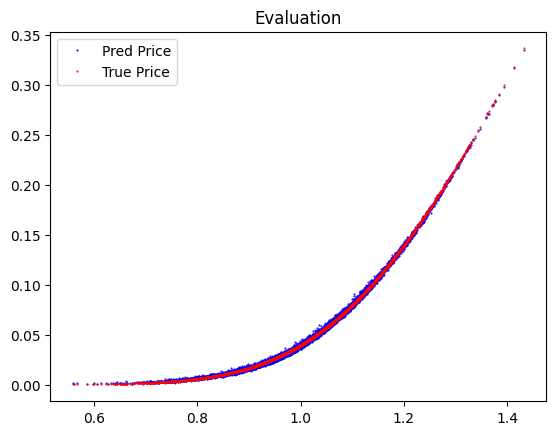

RMSE: 0.001417231629602611


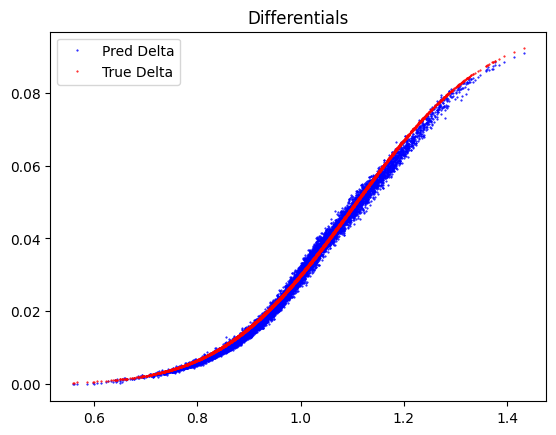

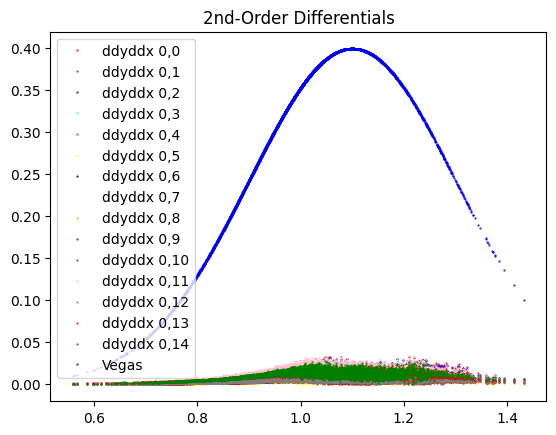

In [203]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

## Experiment

In [52]:
def f(x):
  return x**2

xs = jnp.array([[3., 2., 1.]])
dys = jnp.array([[3., 2., 1.], 
                 [3., 2., 1.], 
                 [3., 2., 1.]])

pcs = jnp.array([[3., 2., 1.], 
                 [1., 1., 1.], 
                 [1., 2., 3.]])

print(xs.shape)
print(dys.shape)

print(xs @ dys)

print(pcs @ dys)
print(dys @ pcs)
# print(jnp.vdot(xs, dys))

hessian = jnp.tile(dys, (256, 1, 1))
print(hessian.shape)
print(pcs.shape)

# broadcasts the pcs accordingly
hvp = pcs @ hessian
print(hvp.shape)


(1, 3)
(3, 3)
[[18. 12.  6.]]
[[18. 12.  6.]
 [ 9.  6.  3.]
 [18. 12.  6.]]
[[12. 10.  8.]
 [12. 10.  8.]
 [12. 10.  8.]]
(256, 3, 3)
(3, 3)
(256, 3, 3)


In [53]:
def f(x):
  return x**2

xs = jnp.array([3.0, 2.0, 1.0])

dys = vmap(grad(f))(xs)
print(dys)
print(dys.shape)
# only now we know the vectors
# vs = 

# jnp.vdot(dys, jnp.ones_like(dys))

vmap(jax.hessian(f))(xs)
jax.hessian(f)(xs)

[6. 4. 2.]
(3,)


Array([[[2., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 2., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 2.]]], dtype=float32)

In [54]:
def f(x):
  return x**2

xs = jnp.array([3.0, 2.0, 1.0])

y, vjp_fn = jax.vjp(f, xs)
print(y)

dy = vjp_fn(jnp.ones_like(y))
print(dy)

dy_vjp, vjpvjp_fn = jax.vjp(vjp_fn, jnp.ones_like(y))
print(dy_vjp)

# ddy = vjpvjp_fn(jnp.ones_like(dy_vjp))
# ddy = vjpvjp_fn((jnp.ones_like(dy_vjp[0]),))
# print(ddy)

# hvp(f, xs, xs)

hess = jax.hessian(f)
print(vmap(hess)(xs))


[9. 4. 1.]
(Array([6., 4., 2.], dtype=float32),)
(Array([6., 4., 2.], dtype=float32),)
[2. 2. 2.]


In [55]:
def f(x):
    return x**2

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (3, 3))
print(x)

y, vjp_fn = jax.vjp(f, x)
print(y)

cotanget = (jnp.ones_like(y[0]), )
dy = vjp_fn(cotanget)
print(len(dy))
cotanget = (jnp.ones_like(dy[0]), )

dy_, vjpvjp_fn = jax.vjp(vjp_fn, cotangent)
if 0:
    print(dy)
    print(dy_)
    dy_ = dy_[0]
    # print(vmap(vjpvjp_fn)((jnp.ones_like(dy_), )))
    print(vjpvjp_fn((jnp.ones_like(dy_), )))

    print(jax.jacobian(f)(x))
    print(jax.hessian(f)(x))


[[-0.38812608 -0.04487164 -2.0427258 ]
 [ 0.07932311 -0.04617044  0.7959976 ]
 [-1.4411978  -1.6929979  -0.37369204]]
[[1.5064184e-01 2.0134645e-03 4.1727285e+00]
 [6.2921550e-03 2.1317096e-03 6.3361222e-01]
 [2.0770509e+00 2.8662419e+00 1.3964574e-01]]


TypeError: Tree structure of cotangent input PyTreeDef((*,)), does not match structure of primal output PyTreeDef(*).

In [ ]:
# with eqx

def f(x):
    return x**2

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (3, 3))
print(x)

y, vjp_fn = eqx.filter_vjp(f, x)
print(y)

dy = vjp_fn(jnp.ones_like(y))
print(dy)

dy, vjpvjp_fn = eqx.filter_vjp(vjp_fn, jnp.ones_like(y))
print(dy)

[[-0.38812608 -0.04487164 -2.0427258 ]
 [ 0.07932311 -0.04617044  0.7959976 ]
 [-1.4411978  -1.6929979  -0.37369204]]
[[1.5064184e-01 2.0134645e-03 4.1727285e+00]
 [6.2921550e-03 2.1317096e-03 6.3361222e-01]
 [2.0770509e+00 2.8662419e+00 1.3964574e-01]]
(Array([[-0.77625215, -0.08974329, -4.0854516 ],
       [ 0.15864621, -0.09234088,  1.5919952 ],
       [-2.8823955 , -3.3859959 , -0.7473841 ]], dtype=float32),)
(Array([[-0.77625215, -0.08974329, -4.0854516 ],
       [ 0.15864621, -0.09234088,  1.5919952 ],
       [-2.8823955 , -3.3859959 , -0.7473841 ]], dtype=float32),)


In [ ]:
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (7,))
# print(x.shape)
y_ = MakeScalar(model)(x)

jac = jax.jacobian(model)(x)
hess = jax.hessian(model)(x)
# y, vjp_fn = eqx.filter_vjp(MakeScalar(model), x)
# print("y", y)

y, J, vjp_fn = value_and_jacrev(model, x)

# print(y.size)

def hvp(f, v):
    dy, vjpvjp_fn = eqx.filter_vjp(f, v)
    dy = dy[0]
    basis = jnp.eye(dy.size, dtype=dy.dtype)
    H = vmap(vjpvjp_fn)((basis,))
    return dy, H

# dy, H = hvp(vjp_fn, jnp.ones_like(y))
# print("dy", dy)
dy, vjpvjp_fn = eqx.filter_vjp(vjp_fn, jnp.ones_like(y))
dy0 = dy[0]
basis = jnp.eye(dy0.size, dtype=dy0.dtype) # same as jnp.eye(x.size, dtype=x.dtype)

def vjpvjp_el(v):
    return vjpvjp_fn((v,)) 

# ddy = vjpvjp_fn((basis[0],))
ddy = vjpvjp_fn((jnp.ones_like(dy0),))
print("dy", dy)
print("ddy", ddy)

H = vmap(vjpvjp_el)(basis)

def hvp(f, primals, tangents):
    return eqx.filter_jvp(eqx.filter_grad(f), primals, tangents)[1]

def hmp(f, primals):

    def hvp_(tangents):
        return hvp(f, (primals,), (tangents, ))

    return eqx.filter_vmap(hvp_)

hvp_res = hvp(MakeScalar(model), (x,), (basis[0],))
print("hvp: ", hvp_res)

hmp_fn = hmp(MakeScalar(model), x)
hvp_res = hmp_fn(basis)
print("hmp: ", hvp_res)

print(y_)
print(y)

print(jac)
print(J)

print(hess)
print(H)

dy (Array([-0.00836775, -0.00073751, -0.00439059, -0.00280592, -0.00235696,
       -0.0056589 , -0.00504256], dtype=float32),)
ddy (Array([-0.02936021], dtype=float32),)
hvp:  [-6.1080320e-04 -2.3331182e-04 -9.3602127e-04 -3.3858477e-04
 -8.6907647e-04 -9.5272699e-06 -1.3695123e-04]
hmp:  [[-6.1080308e-04 -2.3331185e-04 -9.3602127e-04 -3.3858477e-04
  -8.6907664e-04 -9.5272335e-06 -1.3695104e-04]
 [-2.3331189e-04  1.7222749e-04 -3.7502850e-04 -1.7532007e-05
  -5.3374610e-05 -1.4621431e-05 -7.0111157e-04]
 [-9.3602150e-04 -3.7502850e-04 -8.4217149e-04  7.5299118e-04
   5.8836385e-04  4.5638336e-04 -1.5317803e-03]
 [-3.3858471e-04 -1.7531909e-05  7.5299095e-04  7.7574287e-04
   3.8701249e-04 -1.7244610e-04 -6.1574130e-04]
 [-8.6907647e-04 -5.3374501e-05  5.8836397e-04  3.8701255e-04
  -1.8838544e-04 -4.7550054e-04 -5.6692900e-04]
 [-9.5272526e-06 -1.4621274e-05  4.5638336e-04 -1.7244593e-04
  -4.7550065e-04 -4.1496183e-04  1.8320826e-04]
 [-1.3695117e-04 -7.0111186e-04 -1.5317801e-03 -6.

In [ ]:
# now same as above but with a batch of vector data
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (3, 7))
y_ = vmap(MakeScalar(model))(x)

print(x)
print(y_)

jac = vmap(jax.jacobian(model))(x)
hess = eqx.filter_jit(vmap(jax.hessian(model)))(x)

jac_ = vmap(jax.grad(MakeScalar(model)))(x)

def hvp(f, primals, tangents):
    return eqx.filter_jvp(eqx.filter_grad(f), primals, tangents)[1]

def hmp(f, primals):
    
    def hvp_(tangents):
        return hvp(f, (primals,), (tangents, ))

    return eqx.filter_vmap(hvp_)

def batch_hmp(f):

    def hvp_(primals, tangents):
        return hvp(f, (primals,), (tangents,))

    # return eqx.filter_jit(eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1)))
    return eqx.filter_jit(eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1)))


# def batch_hmp_pca(f):

#     def hvp_(primals, tangents):
#         return hvp(f, (primals,), (tangents,))

#     fn = eqx.filter_vmap(hvp_, in_axes=(0, None))
#     jax.lax.cond(pred, lambda x: x, lambda x: jnp.zeros_like(x), x)

#     return eqx.filter_jit(eqx.filter_vmap(, in_axes=(None, 1)))


basis = jnp.eye(x.shape[-1], dtype=x.dtype)
print(basis.shape)
hvp_res = hvp(MakeScalar(model), (x[0],), (basis[0],))


hmp_fn = hmp(MakeScalar(model), x[0])
hvp_res = hmp_fn(basis)

batch_hmp_fn = eqx.filter_jit(batch_hmp(MakeScalar(model)))
batch_hmp_res = batch_hmp_fn(x, basis)
batch_hmp_res = jnp.transpose(batch_hmp_res, (1, 0, 2))
print("batch_hmp_res", batch_hmp_res)

hess_vs_hmp = jnp.allclose(hess[:, 0, :, :], batch_hmp_res)
print("hmp close to hess: ", hess_vs_hmp)


@eqx.filter_jit
def dynamic_slices_do_not_work():
    k = jnp.asarray(jnp.sum(basis), dtype=jnp.int32) - 5
    print('k', k)

    batch_hmp_selected = eqx.filter_jit(batch_hmp_fn)(x, basis[:, :k])
    batch_hmp_selected = jnp.transpose(batch_hmp_selected, (1, 0, 2))
    print("bath_hmp_selected", batch_hmp_selected.shape)
    print("bath_hmp_selected", batch_hmp_selected)

# the following does not work in jax
# dynamic_slices_do_not_work()

# have to avoid jit to make it work
batch_hmp_selected = eqx.filter_jit(batch_hmp_fn)(x, basis[:, :2])
batch_hmp_selected = jnp.transpose(batch_hmp_selected, (1, 0, 2))
print("bath_hmp_selected", batch_hmp_selected.shape)
print("bath_hmp_selected", batch_hmp_selected)

# the following does work in jax
# we first set the tangents we do not want to compute to zero
# such that we internally skip those computations. Whether this is
# faster than computing everything and then selecting the relevant
# parts is unclear.
batch_hmp_fn_select = eqx.filter_jit(batch_hmp_select(MakeScalar(model)))

# mask the basis to only compute the first 5 tangents
# basis_mask = jnp.asarray(jnp.sum(basis), dtype=jnp.int32) - 5
# basis_mask = jnp.concatenate([jnp.ones(basis_mask), jnp.zeros(basis.size - basis_mask)])
# basis_mask = jnp.reshape(basis_mask, basis.shape)

# in numpy zero out the next n columns of basis
basis_masked = basis.at[:, 2:].set(0.)
batch_hmp_res = batch_hmp_fn_select(x, basis_masked)
batch_hmp_res = jnp.transpose(batch_hmp_res, (1, 0, 2))
print("batch_hmp_pca_res", batch_hmp_res)

print("jac from grad shape", jac_.shape)
print("jac from grad: ", jac_)
print("jacobian.shape", jac.shape)
print("jacobian", jac)
print("hessian.shape", hess.shape)
print("hessian", hess)

[[-1.0110744   0.8579503  -1.408211    0.30537882 -0.5529018  -0.20745467
  -0.91298896]
 [ 0.8951212  -1.7360477   0.47285226 -1.2633834   0.03138541  1.3681892
  -0.83616734]
 [-0.6514678   1.1204553  -2.0303192   0.5996085  -0.8729886   0.93188107
  -0.01794553]]
[0.03812329 0.00545319 0.02495258]
(7, 7)
batch_hmp_res [[[-3.3906644e-04 -7.7072233e-05 -7.4307172e-04 -7.3547720e-04
   -1.3029812e-03 -1.6769826e-04  7.4271910e-04]
  [-7.7072327e-05  7.7760153e-05 -2.1127101e-04  1.9880421e-05
   -2.7794237e-04 -2.2684189e-05 -3.4409881e-04]
  [-7.4307207e-04 -2.1127108e-04 -3.3174560e-04  5.8598543e-04
    2.5427618e-04  2.0159592e-04 -1.1795548e-03]
  [-7.3547708e-04  1.9880550e-05  5.8598537e-04  8.7144633e-04
    5.7646551e-04 -2.2871024e-04 -1.4743009e-03]
  [-1.3029811e-03 -2.7794242e-04  2.5427606e-04  5.7646557e-04
    1.0763346e-04 -3.4260331e-04 -1.2564788e-03]
  [-1.6769831e-04 -2.2684231e-05  2.0159601e-04 -2.2871017e-04
   -3.4260339e-04 -4.7583476e-04 -2.2669775e-04]
  [ 7

In [ ]:
# (small) benchmark 
# we observe that doing a select is slower than computing everything

key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (8 * 1024, 100))
y = jax.random.normal(subkey, (8 * 1024, 1))
basis = jnp.eye(x.shape[-1], dtype=x.dtype)

key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x.shape[1], out_size=y.shape[1])

batch_hmp_fn = eqx.filter_jit(batch_hmp(MakeScalar(model)))
batch_hmp_fn_select = eqx.filter_jit(batch_hmp_select(MakeScalar(model)))
%timeit batch_hmp_fn_select(x, basis) 
%timeit batch_hmp_fn(x, basis) 

basis_masked = basis.at[:, 2:].set(0.)

%timeit batch_hmp_fn_select(x, basis_masked) 
%timeit batch_hmp_fn(x, basis_masked) 



408 µs ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
296 µs ± 41.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.9 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.9 ms ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:

res_select = batch_hmp_fn_select(x, basis) 
res_normal = batch_hmp_fn(x, basis) 

print(res_select.shape)
# print(res_normal)
# print(jnp.sum(res_select - res_normal))

NameError: name 'batch_hmp_fn_select' is not defined

In [57]:
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (7,))
# print(x.shape)
y_ = MakeScalar(model)(x)
# print(y_)

y, vjp_fn = eqx.filter_vjp(MakeScalar(model), x)
print("y", y)

cotangent = jnp.ones_like(y)
dy, vjpvjp_fn = eqx.filter_vjp(vjp_fn, cotangent)
print("dy", dy)
print(vjp_fn(cotangent))

# ddy = vjpvjp_fn((jnp.ones_like(dy[0]),))
ddy = vjpvjp_fn(dy)
print("ddy", ddy)
print("x", x)

print(jax.hessian(model)(x))
print(jax.hessian(MakeScalar(model))(x))

# print(jax.vmap(jax.grad)(jax.grad(MakeScalar(model)))(x))

# eqx.filter_vmap(eqx.filter_grad)(eqx.filter_grad(MakeScalar(model)))(x)

if 0:
    y, vjp_fn = eqx.filter_vmap(partial(eqx.filter_vjp, MakeScalar(model)))(x)
    print(y)
    print(y.shape)
    # dy = eqx.filter_vmap(vjp_fn)(jnp.ones_like(x))
    # dy = vjp_fn((jnp.array([1.0]),))

    cotangent = jnp.ones(shape=())
    vjp_fn(cotangent)

y -0.013149001
dy (Array([ 0.00407964,  0.00996458,  0.00045701,  0.00246731,  0.01029229,
        0.00188987, -0.00032944], dtype=float32),)
(Array([ 0.00407964,  0.00996458,  0.00045701,  0.00246731,  0.01029229,
        0.00188987, -0.00032944], dtype=float32),)
ddy (Array(0.00023184, dtype=float32),)
x [-1.4986218  -0.05708544  0.09740688 -0.0673765  -0.90798175  0.17307237
  0.39909264]
[[[ 3.7015339e-03 -9.5647189e-04  3.4639451e-03  1.5701923e-04
   -1.6476470e-03  2.0245179e-03  1.9244381e-03]
  [-9.5647160e-04  2.5739521e-03 -3.9923601e-03 -1.6734296e-03
    3.5150332e-04 -1.7534450e-03 -2.5777954e-03]
  [ 3.4639449e-03 -3.9923610e-03  2.5150692e-03 -2.5630192e-04
   -3.4998145e-03  5.0159247e-04  1.6032613e-03]
  [ 1.5701915e-04 -1.6734299e-03 -2.5630163e-04 -1.4354529e-04
   -1.1739540e-03 -4.9362372e-04  2.0765999e-04]
  [-1.6476471e-03  3.5150276e-04 -3.4998143e-03 -1.1739542e-03
    1.0754332e-03 -1.7362719e-03 -1.9456412e-03]
  [ 2.0245172e-03 -1.7534447e-03  5.0159270e-

In [58]:
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (7, 7))
# print(x.shape)
y_ = vmap(MakeScalar(model))(x)
# print(y_)

y, vjp_fn = eqx.filter_vmap(partial(eqx.filter_vjp, MakeScalar(model)))(x)
print(y)
print(y.shape)
# dy = eqx.filter_vmap(vjp_fn)(jnp.ones_like(x))
# dy = vjp_fn((jnp.array([1.0]),))

cotangent = jnp.ones(shape=())
vjp_fn(cotangent)

[-0.00530234  0.0136837   0.01398236 -0.00030544 -0.00558965 -0.03030739
 -0.00791175]
(7,)


TypeError: dot_general requires lhs dimension numbers to be nonnegative and less than the number of axes of the lhs value, got lhs_batch of () and lhs_contracting of (0, 1) for lhs of rank 1

In [ ]:
# experiment with using finite differences over vjp

def f(x):
  return 2 * x**3

xs = jnp.array([1.0, 2.0])
y, vjp_fn = jax.vjp(f, xs)
print(y)

cotangent = jnp.ones_like(y)
print(cotangent)
dy, vjpvjp_fn = jax.vjp(vjp_fn, cotangent)
print(dy)

# using ad
ddy = vjpvjp_fn((jnp.ones_like(y), ))
print(ddy)

# now using fd, NOTE: I don't actually need vjpvjp here
h = 1e-3

fd_xph = f(xs + jnp.array([h, h]))
fd_xmh = f(xs - jnp.array([h, h]))
fd = (fd_xph - fd_xmh) / (2 * h)
print("FD of f(x)")
print(fd)


fdd_xph, = vjp_fn(cotangent + jnp.array([h, h]))
fdd_xmh, = vjp_fn(cotangent - jnp.array([h, h]))

print(fdd_xph)
print(fdd_xmh)
fdd = (fdd_xph - fdd_xmh) / (2 * h)

print("FD over vjp of f(x)")
print(fdd)

grad_f = grad(f)

fdd_xph = vmap(grad_f)(xs + h)
fdd_xmh = vmap(grad_f)(xs - h)
fdd = (fdd_xph - fdd_xmh) / (2 * h)
print("FD over grad of f(x)")
print(fdd)

jax.hessian(f)(xs)

[ 2. 16.]
[1. 1.]
(Array([ 6., 24.], dtype=float32),)
(Array([ 6., 24.], dtype=float32),)
FD of f(x)
[ 6.0000415 23.99969  ]
[ 6.0060005 24.024002 ]
[ 5.994 23.976]
FD over vjp of f(x)
[ 6.00028 24.00112]
FD over grad of f(x)
[12.000083 23.999212]


Array([[[12.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0., 24.]]], dtype=float32)

In [ ]:
def f(x):
    return x**2

partial_vjp = partial(jax.vjp, f)

# xs = jnp.array([[3.0, 2.0, 1.0], [6.0, 5.0, 4.0], [9., 8., 7.]])
xs = jnp.array([3.0, 2.0, 1.0])
# xs = jnp.tile(xs, (5, 1))

# xs = jax.random.normal(key, shape=(256, 7))
print(xs)
# xs = jnp.array(1.0)

y, vjp_fn = partial_vjp(xs)
# y, vjp_fn = partial_vjp(xs)
print(y)

print(y[0].shape)
print(y[0])

print(vjp_fn)

dy = vjp_fn(jnp.ones_like(y))
print(dy)

[3. 2. 1.]
[9. 4. 1.]
()
9.0
Partial(_HashableCallableShim(functools.partial(<function _vjp_pullback_wrapper at 0x7ff45e4895a0>, 'f', [dtype('float32')], [(3,)], (PyTreeDef(*), PyTreeDef((*,))))), Partial(_HashableCallableShim(functools.partial(<function vjp.<locals>.unbound_vjp at 0x7ff0964c8040>, [(ShapedArray(float32[3]), None)], { lambda a:f32[3]; b:f32[3]. let c:f32[3] = mul b a in (c,) })), (Array([6., 4., 2.], dtype=float32),)))
(Array([6., 4., 2.], dtype=float32),)


In [ ]:

def inner_fn(x):
    return x ** 3

def outer_fn(x):
    # def inner(x, y):
        # return inner_fn(x, y)
    
    _, vjp_inner = jax.vjp(inner_fn, x)
    cotangent = jnp.ones_like(x)
    grad_inner_x, = vjp_inner(x)
    return grad_inner_x

# Example usage
# x = jnp.array([2.0, 1.0])
x = jnp.array(1.0)
y = jnp.array(3.0)

grad_inner_x, vjp_outer = jax.vjp(outer_fn, x)
grad_outer_x = vjp_outer(1.0)

print(f"Gradient of inner_fn with respect to x: {grad_inner_x}")
print(f"Gradient of outer_fn with respect to x: {grad_outer_x}")
# print(f"Gradient of outer_fn with respect to y: {grad_outer_y}")

Gradient of inner_fn with respect to x: 3.0
Gradient of outer_fn with respect to x: (Array(9., dtype=float32, weak_type=True),)


In [ ]:
def f(x):
    return x**2

partial_vjp = partial(jax.vjp, f)

xs = jnp.array([[3.0, 2.0, 1.0], [6.0, 5.0, 4.0], [9., 8., 7.]])
# xs = jnp.array([3.0, 2.0, 1.0])
# xs = jnp.tile(xs, (5, 1))

# xs = jax.random.normal(key, shape=(256, 7))
print(xs)
# xs = jnp.array(1.0)

y, vjp_fn = eqx.filter_vmap(partial_vjp)(xs)
# y, vjp_fn = partial_vjp(xs)
print(y)

print(y[0].shape)
print(y[0])

print(vjp_fn)


# this is an internal problem of the generated vjp_fn since 
# it probably gets confused with the vmap
# print(vjp_fn(jnp.ones_like(y[0])))

# but the below also doesn't work
# print(vjp_fn(jnp.ones_like(y)))

# print(vmap(vjp_fn)(jnp.ones(shape=(3,3))))


[[3. 2. 1.]
 [6. 5. 4.]
 [9. 8. 7.]]
[[ 9.  4.  1.]
 [36. 25. 16.]
 [81. 64. 49.]]
(3,)
[9. 4. 1.]
Partial(_HashableCallableShim(functools.partial(<function _vjp_pullback_wrapper at 0x7ff45e4895a0>, 'f', [dtype('float32')], [(3,)], (PyTreeDef(*), PyTreeDef((*,))))), Partial(_HashableCallableShim(functools.partial(<function vjp.<locals>.unbound_vjp at 0x7ff210469fc0>, [(ShapedArray(float32[3]), None)], { lambda a:f32[3]; b:f32[3]. let c:f32[3] = mul b a in (c,) })), (Array([[ 6.,  4.,  2.],
       [12., 10.,  8.],
       [18., 16., 14.]], dtype=float32),)))


In [ ]:
def f(x):
    return x**2

# maybe first vmap the vjp?
# partial_vjp = partial(jax.vjp, f)
vmap_vjp = vmap(lambda x: jax.vjp(f, x))

xs = jnp.array([[3.0, 2.0, 1.0], [6.0, 5.0, 4.0], [9., 8., 7.]])
# xs = jnp.array([3.0, 2.0, 1.0])
# xs = jnp.tile(xs, (5, 1))

# xs = jax.random.normal(key, shape=(256, 7))
print(xs)
# xs = jnp.array(1.0)

y, vjp_fn = vmap_vjp(xs)
# y, vjp_fn = partial_vjp(xs)
print(y)

print(y[0].shape)
print(y[0])


#print(vjp_fn(jnp.ones_like(y)))


[[3. 2. 1.]
 [6. 5. 4.]
 [9. 8. 7.]]
[[ 9.  4.  1.]
 [36. 25. 16.]
 [81. 64. 49.]]
(3,)
[9. 4. 1.]
